##Objective
The goal is to forecast weekly Walmart sales using the legacy dataset. We're showing insights into trends, seasonality, and anomalies, and demonstrate the effectiveness of forecasting models.

##Key deliverables

* Accurate sales forecasts.
* Insights into trends and patterns
* Comparison of different forecasting methods (e.g., AutoRegressor, Propher, and two versions of Random Forests).

# Reading the data

In [1]:
!pip install kaggle
!pip install kagglehub

import kagglehub

import pandas as pd
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get datasets
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

# view all columns when using pandas
pd.pandas.set_option('display.max_columns', None)

100%|██████████| 3.36M/3.36M [00:00<00:00, 37.5MB/s]

Extracting files...


In [3]:
# read datasets
features_df = pd.read_csv(f"{path}/features.csv")
stores_df = pd.read_csv(f"{path}/stores.csv")
test_df = pd.read_csv(f"{path}/test.csv")
train_df = pd.read_csv(f"{path}/train.csv")

# Exploring the data

## Data Summary

In [4]:
# view each dataset
print("Features.csv")
print(features_df.head())

nan_count_per_column = features_df.isna().sum()
print(nan_count_per_column)

duplicates = features_df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")
#########################

print("\nStores.csv")
print(stores_df.head())

nan_count_per_column = stores_df.isna().sum()
print(nan_count_per_column)

duplicates = stores_df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")
#########################

print("\nTest.csv")
print(test_df.head())

nan_count_per_column = test_df.isna().sum()
print(nan_count_per_column)

duplicates = test_df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")
#########################

print("\nTrain.csv")
print(train_df.head())

nan_count_per_column = train_df.isna().sum()
print(nan_count_per_column)

duplicates = train_df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Features.csv
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2  

In [5]:
print(train_df.describe())

               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.000000      99.000000  693099.360000


## Data Visualization

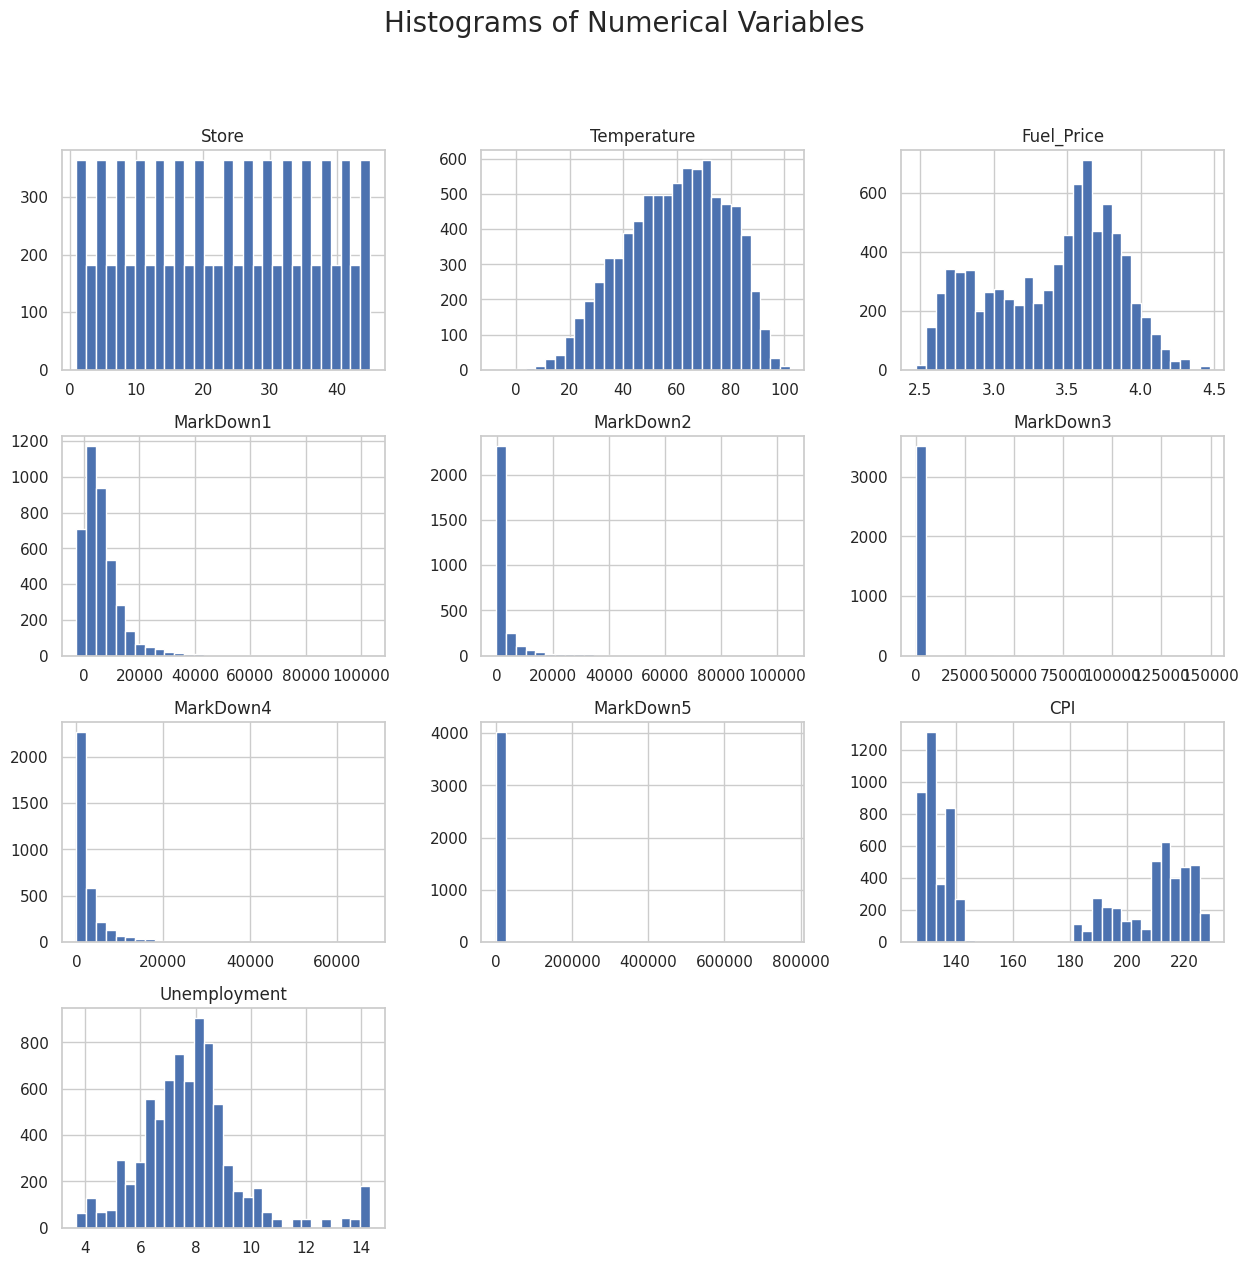

In [6]:
sns.set(style="whitegrid")
features_df.hist(bins=30, figsize=(15, 14))
plt.suptitle('Histograms of Numerical Variables', fontsize=20)
plt.show()

<Axes: >

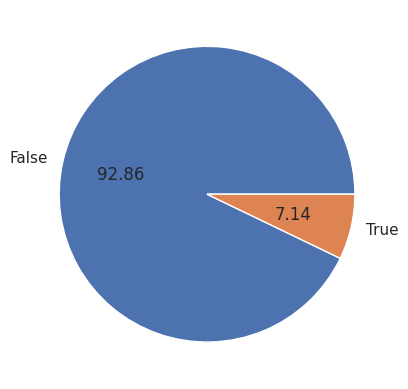

In [7]:
features_df.groupby('IsHoliday').size().plot(kind='pie', autopct='%.2f')

### Unemployment Rate vs. Time

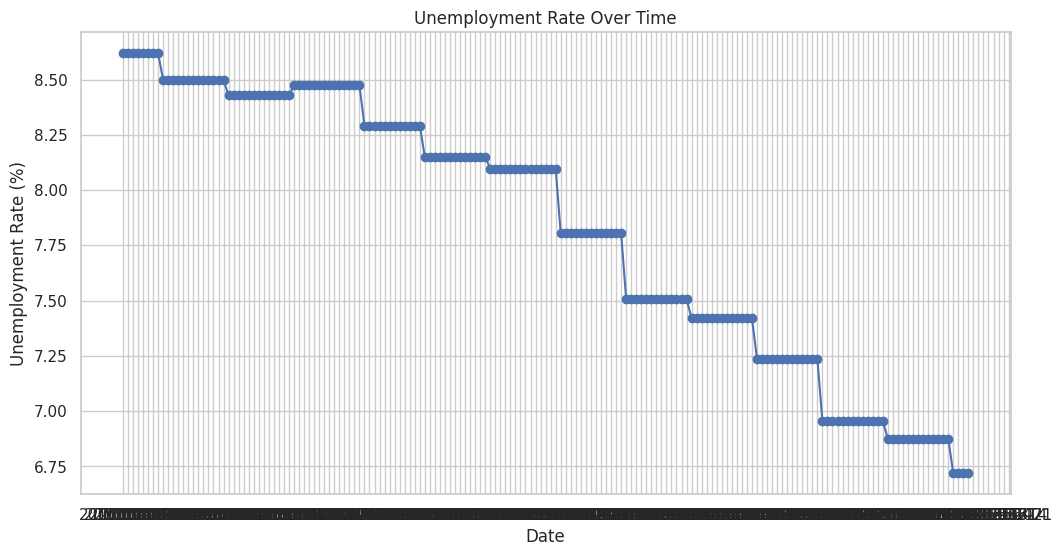

In [8]:
grouped_df = features_df.groupby('Date')['Unemployment'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(grouped_df['Date'], grouped_df['Unemployment'], marker='o', linestyle='-')

plt.title('Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')

plt.grid(True)
plt.show()

### CPI Index vs. time

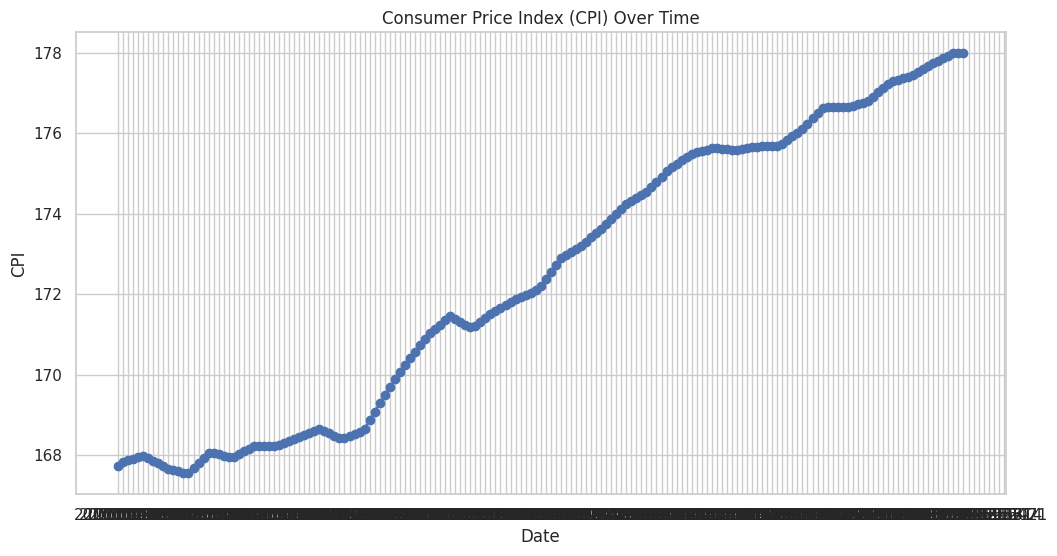

In [9]:
grouped_cpi_df = features_df.groupby('Date')['CPI'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(grouped_cpi_df['Date'], grouped_cpi_df['CPI'], marker='o', linestyle='-')

plt.title('Consumer Price Index (CPI) Over Time')
plt.xlabel('Date')
plt.ylabel('CPI')

plt.grid(True)
plt.show()

### Fuel Price vs. time

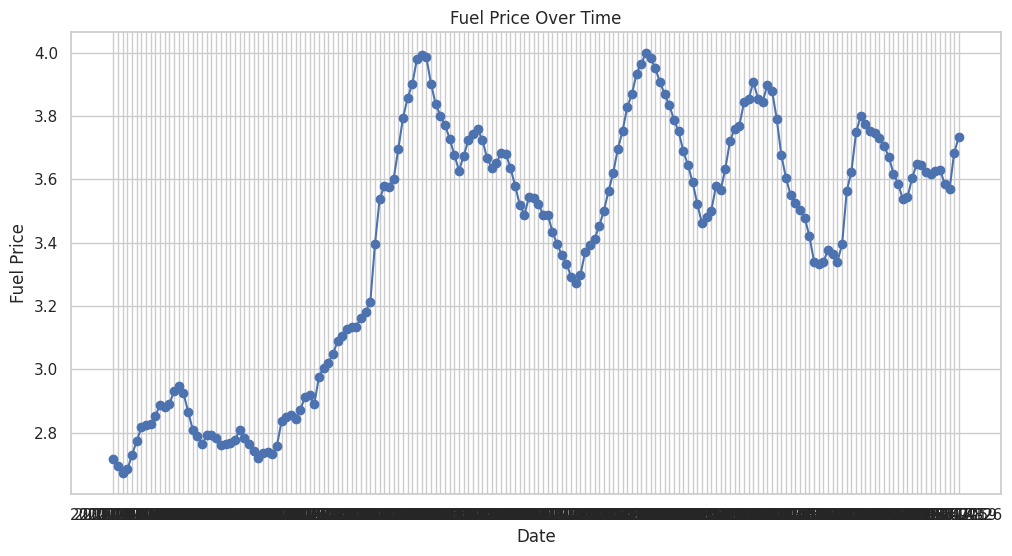

In [10]:
grouped_fuel_price_df = features_df.groupby('Date')['Fuel_Price'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(grouped_fuel_price_df['Date'], grouped_fuel_price_df['Fuel_Price'], marker='o', linestyle='-')

plt.title('Fuel Price Over Time')
plt.xlabel('Date')
plt.ylabel('Fuel Price')

plt.grid(True)
plt.show()

### Normalized comparision of Unemployment rate vs. CPI vs. Fuel Price

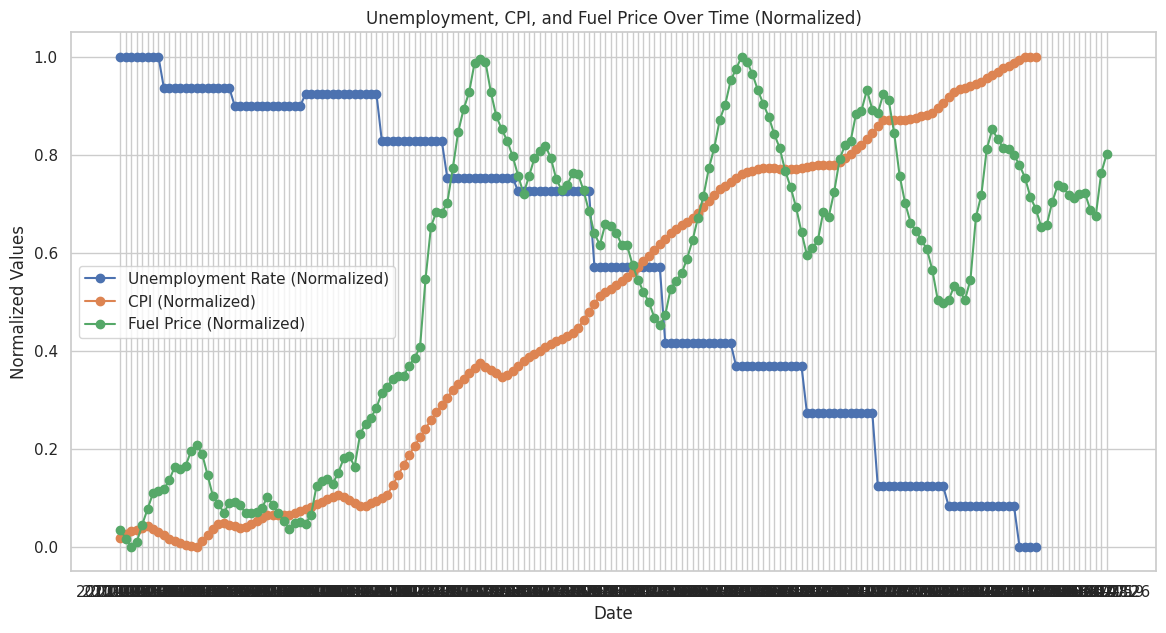

In [11]:
df_grouped = features_df.groupby('Date').mean().reset_index()

df_grouped['Unemployment_norm'] = (df_grouped['Unemployment'] - df_grouped['Unemployment'].min()) / (df_grouped['Unemployment'].max() - df_grouped['Unemployment'].min())
df_grouped['CPI_norm'] = (df_grouped['CPI'] - df_grouped['CPI'].min()) / (df_grouped['CPI'].max() - df_grouped['CPI'].min())
df_grouped['Fuel_Price_norm'] = (df_grouped['Fuel_Price'] - df_grouped['Fuel_Price'].min()) / (df_grouped['Fuel_Price'].max() - df_grouped['Fuel_Price'].min())

plt.figure(figsize=(14, 7))

plt.plot(df_grouped['Date'], df_grouped['Unemployment_norm'], marker='o', linestyle='-', label='Unemployment Rate (Normalized)')
plt.plot(df_grouped['Date'], df_grouped['CPI_norm'], marker='o', linestyle='-', label='CPI (Normalized)')
plt.plot(df_grouped['Date'], df_grouped['Fuel_Price_norm'], marker='o', linestyle='-', label='Fuel Price (Normalized)')


plt.title('Unemployment, CPI, and Fuel Price Over Time (Normalized)')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)
plt.show()

### Analysis for Sales Trends Over Time

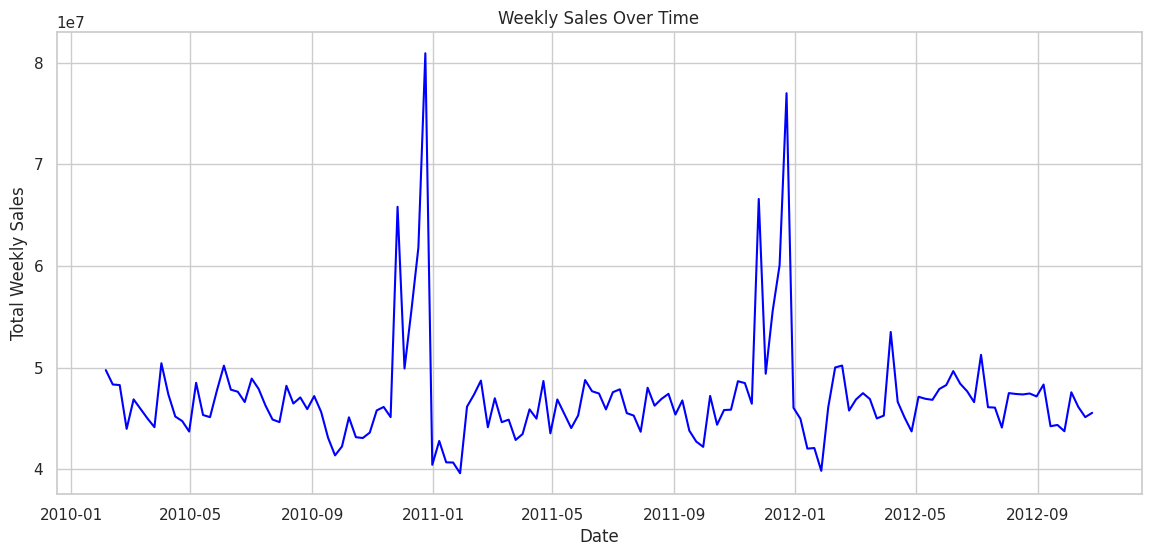

In [12]:
import matplotlib.pyplot as plt

# I'm ensuring the date column is in datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])

# now it could be useful to aggregate weekly sales data by date
weekly_sales = train_df.groupby('Date')['Weekly_Sales'].sum()

# plotting
plt.figure(figsize=(14, 6))
plt.plot(weekly_sales.index, weekly_sales.values, color='blue')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()

We can see that there are very similar spikes in sales in the weeks approaching the end of the years 2010 and 2011.

### Store-Level Analysis

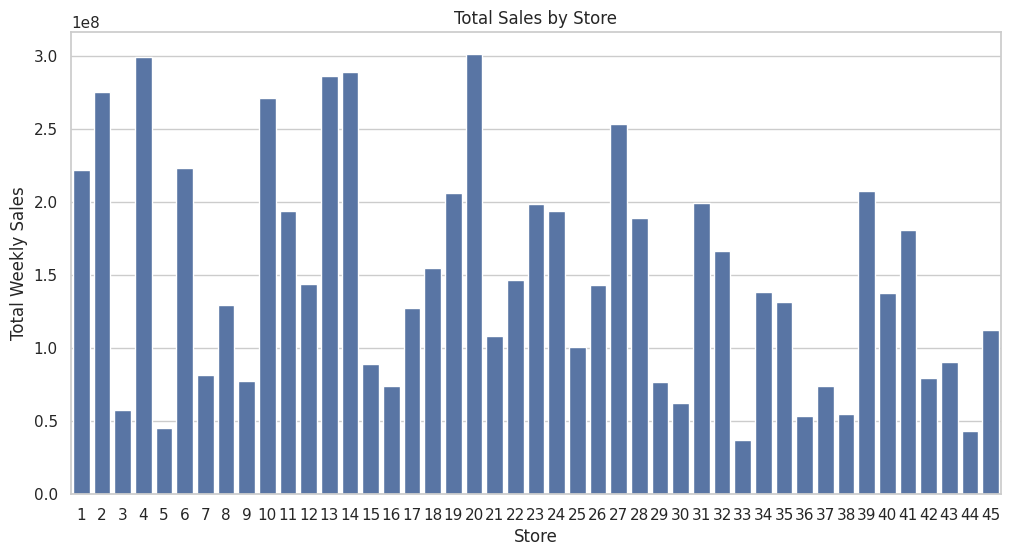

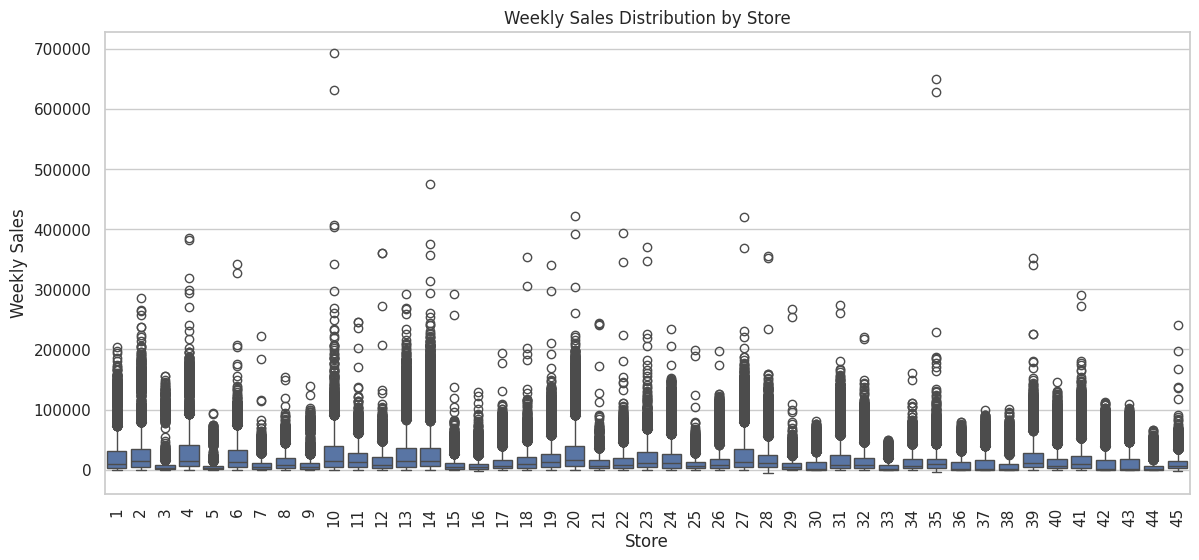

In [13]:
import seaborn as sns

# we can look at both total sales by store and weekly sales for each store
# total sales by store
store_sales = train_df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=store_sales.index, y=store_sales.values)
plt.title('Total Sales by Store')
plt.xlabel('Store')
plt.ylabel('Total Weekly Sales')
plt.show()
# weekly sales for each store
plt.figure(figsize=(14, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=train_df)
plt.title('Weekly Sales Distribution by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=90)
plt.show()

### Holiday Sales Analysis

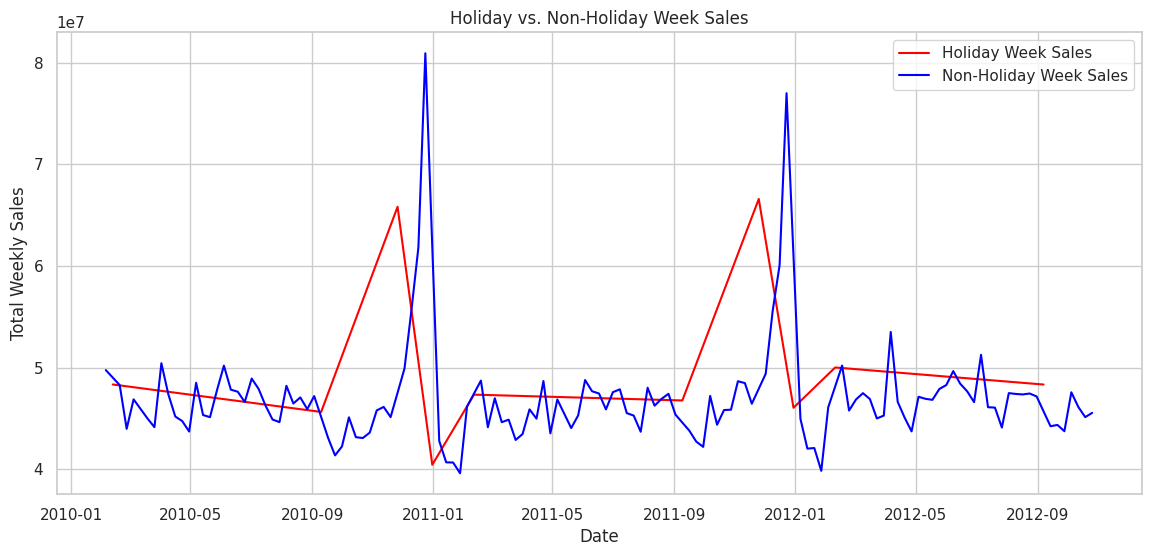

In [14]:
# we're also interested to see how sales are affected during holiday and non-holiday weeks
holiday_sales = train_df[train_df['IsHoliday'] == True].groupby('Date')['Weekly_Sales'].sum()
non_holiday_sales = train_df[train_df['IsHoliday'] == False].groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(14, 6))
plt.plot(holiday_sales.index, holiday_sales.values, label='Holiday Week Sales', color='red')
plt.plot(non_holiday_sales.index, non_holiday_sales.values, label='Non-Holiday Week Sales', color='blue')
plt.title('Holiday vs. Non-Holiday Week Sales')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.legend()
plt.show()

Both kinds of sales surge at the end of the year and drop roughly in January.

In [15]:
# Convert Date column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Week'] = train_df['Date'].dt.isocalendar().week
train_df['Day'] = train_df['Date'].dt.day

# check data type
print(train_df.dtypes)

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Year                     int32
Month                    int32
Week                    UInt32
Day                      int32
dtype: object


#Data Preprocessing


In [16]:
features_df['CPI'] = features_df['CPI'].fillna(method='ffill').fillna(method='bfill')
features_df['Unemployment'] = features_df['Unemployment'].fillna(method='ffill').fillna(method='bfill')

<ipython-input-16-409b3f6a1dbd>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['CPI'] = features_df['CPI'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-16-409b3f6a1dbd>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['Unemployment'] = features_df['Unemployment'].fillna(method='ffill').fillna(method='bfill')


In [17]:
for i in range(1, 6):
    features_df["MarkDown" + str(i)] = features_df["MarkDown" + str(i)].apply(lambda x: 0 if x < 0 else x)
    features_df["MarkDown" + str(i)].fillna(value=0, inplace=True)

<ipython-input-17-ca83bf117524>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features_df["MarkDown" + str(i)].fillna(value=0, inplace=True)


In [18]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     8190 non-null   float64
 5   MarkDown2     8190 non-null   float64
 6   MarkDown3     8190 non-null   float64
 7   MarkDown4     8190 non-null   float64
 8   MarkDown5     8190 non-null   float64
 9   CPI           8190 non-null   float64
 10  Unemployment  8190 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [19]:
# changing data to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
for df in [train_df, features_df, test_df]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day

print(train_df.dtypes)
print(test_df.dtypes)
print(features_df.dtypes)

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Year                     int32
Month                    int32
Week                    UInt32
Day                      int32
dtype: object
Store                 int64
Dept                  int64
Date         datetime64[ns]
IsHoliday              bool
Year                  int32
Month                 int32
Week                 UInt32
Day                   int32
dtype: object
Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
Year                     int32
Month                    int32
Week                    UInt32
Day 

We're merging three dataframes: `features.csv`, `train.csv`, and `stores.csv`.

In [20]:
# Merge datasets
train_df = train_df.merge(features_df, on=['Store', 'Date'], how='left')
train_df = train_df.merge(stores_df, on='Store', how='left')
test_df = test_df.merge(features_df, on=['Store', 'Date'], how='left')
test_df = test_df.merge(stores_df, on='Store', how='left')

print("Columns in train DataFrame after merging:", train_df.columns.tolist())
print("Columns in test DataFrame after merging:", test_df.columns.tolist())

print("Train after merge:", train_df.shape)
print("Number of missing values after merge:")
print(train_df.isnull().sum())

Columns in train DataFrame after merging: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Year_x', 'Month_x', 'Week_x', 'Day_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Year_y', 'Month_y', 'Week_y', 'Day_y', 'Type', 'Size']
Columns in test DataFrame after merging: ['Store', 'Dept', 'Date', 'IsHoliday_x', 'Year_x', 'Month_x', 'Week_x', 'Day_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Year_y', 'Month_y', 'Week_y', 'Day_y', 'Type', 'Size']
Train after merge: (421570, 25)
Number of missing values after merge:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday_x     0
Year_x          0
Month_x         0
Week_x          0
Day_x           0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI  

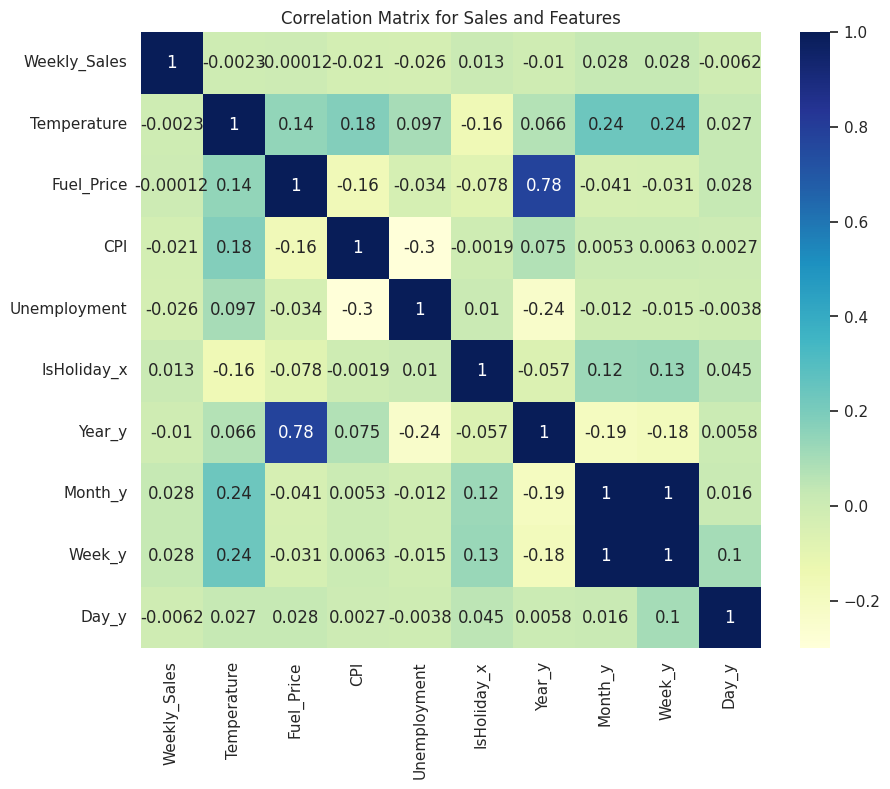

In [21]:
# I want to look at analyze correlations between different features

# I'll make sure features_df also has Date values of type Date
features_df['Date'] = pd.to_datetime(features_df['Date'])

# here's my correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = train_df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','IsHoliday_x', 'Year_y', 'Month_y', 'Week_y', 'Day_y']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix for Sales and Features')
plt.show()

We can see that there is a negative correlation between Unemployment and CPI. Additionally,there's a slight positive correlation between Temperature and both Fuel Price and CPI.

In [22]:
columns_to_drop = ['IsHoliday_y', 'Year_y', 'Month_y', 'Week_y', 'Day_y']

train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

train_df = train_df.rename(columns=lambda col: col.replace('_x', ''))
test_df = test_df.rename(columns=lambda col: col.replace('_x', ''))

In [23]:
# Convert 'IsHoliday' to integer (False=0, True=1)
train_df['IsHoliday'] = train_df['IsHoliday'].astype(int)
test_df['IsHoliday'] = test_df['IsHoliday'].astype(int)

# Confirm the data types
print(train_df.dtypes)
print(train_df.shape)

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                int64
Year                     int32
Month                    int32
Week                    UInt32
Day                      int32
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object
(421570, 20)


In [24]:
walmart_df = train_df.copy()

# Next Steps


After we took a look at the general trends, the next steps will be preparing the data for modeling. This includes handling missing values; we will need to find an imputation approach. We are interested in seeing time-based trends, so we will see how we can extract features from the data we have (maybe creating something like previous weeks' sales or date-based features). We will also need to select a model. For now, a linear regression model seems plausible since we have time-based features. However this is open to discussion for next milestones.  

# Further Data understanding and data preparation

##Understanding Store and Department data

In [25]:
# number of unique stores in our dataset
unique_stores = walmart_df['Store'].nunique()
print(f"Number of unique stores: {unique_stores}")

Number of unique stores: 45


In [26]:
# number of departments
unique_departments = walmart_df['Dept'].nunique()
print(f"Number of unique departments: {unique_departments}")

Number of unique departments: 81


In [27]:
# charting the average weekly sales for each store and department
average_weekly_sales = walmart_df.groupby(['Store', 'Dept'])['Weekly_Sales'].mean().reset_index()
print(average_weekly_sales.head())

   Store  Dept  Weekly_Sales
0      1     1  22513.322937
1      1     2  46102.090420
2      1     3  13150.478042
3      1     4  36964.154476
4      1     5  24257.941119


In [28]:
# representing the weekly sales data with a pivot table
pivot_table = average_weekly_sales.pivot(index='Store', columns='Dept', values='Weekly_Sales')
print(pivot_table.head())

Dept             1             2             3             4             5   \
Store                                                                         
1      22513.322937  46102.090420  13150.478042  36964.154476  24257.941119   
2      30777.980769  65912.922517  17476.563357  45607.666573  30555.315315   
3       7328.621049  16841.775664   5509.300769   8434.186503  11695.366573   
4      36979.940070  93639.315385  19012.491678  56603.400140  45668.406783   
5       9774.553077  12317.953287   4101.085175   9860.806783   6699.202238   

Dept            6             7             8             9             10  \
Store                                                                        
1      4801.780140  24566.487413  35718.257622  28062.052238  31033.386364   
2      6808.382517  40477.837063  58707.369441  34375.864476  38845.854476   
3      2012.411818  10044.341608   8310.254196   9062.007692  10871.944126   
4      8241.777692  50728.151399  62949.723776  34437.17

Some departments have missing values, such as department 99 for stores 3, 5, 9, 10, 25, 35, 42, and 45. We'll further analyze the sales data using a bar chart.

---



In [29]:
!pip install plotly


In [30]:
import pandas as pd
import plotly.express as px

# Assuming `pivot_table` is your prepared pivot table
pivot_table = average_weekly_sales.pivot(index='Store', columns='Dept', values='Weekly_Sales')
pivot_table = pivot_table.reset_index()

# Handle missing and negative values
pivot_table = pivot_table.fillna(-55)  # Replace NaN with -999 as a placeholder
df_melted = pivot_table.melt(id_vars='Store', var_name='Dept', value_name='Weekly_Sales')

# Add a status column to differentiate missing/negative/valid data
def classify_sales(value):
    if value == -55:
        return 'Missing'
    elif value < 0:
        return 'Negative'
    else:
        return 'Valid'

df_melted['Status'] = df_melted['Weekly_Sales'].apply(classify_sales)

# Plot grouped bar chart with custom colors for missing/negative values
fig = px.bar(
    df_melted,
    x='Store',
    y='Weekly_Sales',
    color='Status',
    title='Average Weekly Sales by Department and Store (Including Missing/Negative Values)',
    labels={
        'Weekly_Sales': 'Average Weekly Sales',
        'Store': 'Store',
        'Dept': 'Department',
        'Status': 'Data Status'
    },
    height=600
)

for trace in fig.data:
    if trace.name == 'Valid':
        trace.visible = 'legendonly'


# Update layout to allow full vertical pan/zoom
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        dtick=1,
        rangeslider=dict(visible=True),
        range=[0, 10],
    ),
    yaxis=dict(
        fixedrange=False,
    ),
    barmode='group',
    margin=dict(l=40, r=40, t=40, b=40),
    legend=dict(title='Data Status')
)

# Show interactive plot
fig.show()

As we can see from the graph above, there are negative and missing weekly sales. Both of these do not make sense in the context of our data since sales cannot be negative. To handle this ambiguous and likely misleading data, we will change such values

In [31]:
# show weekly sales less than 0
zero_weekly_sales = walmart_df[walmart_df['Weekly_Sales'] == 0]
negative_weekly_sales = walmart_df[walmart_df['Weekly_Sales'] < 0]
num_zero_weekly_sales = zero_weekly_sales.shape[0]
num_negative_weekly_sales = negative_weekly_sales.shape[0]
print(f"Number of rows with zero weekly sales: {num_zero_weekly_sales}")
print(f"Number of rows with negative weekly sales: {num_negative_weekly_sales}")

Number of rows with zero weekly sales: 73
Number of rows with negative weekly sales: 1285


We can see that there were 73 departments that had no weekly sales and 1285 that had negative weekly sales. It's also very odd for a department not to sale anything in a whole week, so we will also alter these values

In [32]:
walmart_df.shape

(421570, 20)

In [33]:
(num_zero_weekly_sales + num_negative_weekly_sales) / walmart_df.shape[0]

0.003221291837654482

We can see that only 0.3% of the total records had ambiguous sales therefore we'll simply drop these potentially corrupt rows

In [34]:
walmart_df = walmart_df[walmart_df['Weekly_Sales'] > 0]
walmart_df.shape

(420212, 20)

Now we're left with 420,212 records

## Analyzing Holiday data

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

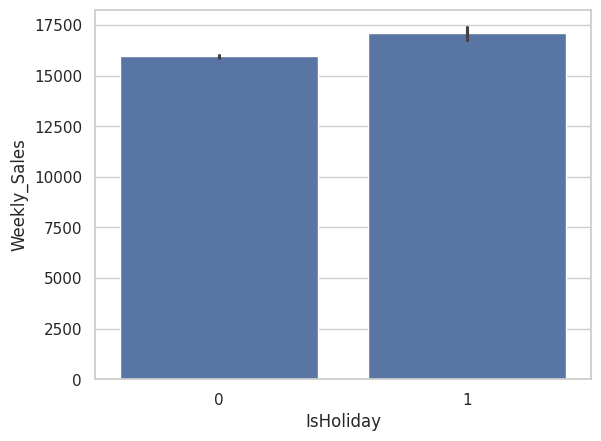

In [35]:
# barplot showing relationship between sales and holiday or non-holiday data
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=walmart_df)

We can see that there were more average sales during holiday than non-holiday days. Now let's see if all holidays were included in the data

In [36]:
# finding if all holidays were included in the data
holidays = walmart_df[walmart_df['IsHoliday'] == True]['Date'].unique()
print(holidays)
print(holidays.size)

<DatetimeArray>
['2010-02-12 00:00:00', '2010-09-10 00:00:00', '2010-11-26 00:00:00',
 '2010-12-31 00:00:00', '2011-02-11 00:00:00', '2011-09-09 00:00:00',
 '2011-11-25 00:00:00', '2011-12-30 00:00:00', '2012-02-10 00:00:00',
 '2012-09-07 00:00:00']
Length: 10, dtype: datetime64[ns]
10


In [37]:
# list of holiday dates in 2010, 2011, and 2012

holidays = [
    {"name": "New Year's Day", "dates": [
        {"actual": "2010-01-01", "observed": "2010-01-01"},
        {"actual": "2011-01-01", "observed": "2010-12-31"},
        {"actual": "2012-01-01", "observed": "2012-01-02"}
    ]},
    {"name": "Martin Luther King Jr. Day", "dates": [
        {"actual": "2010-01-18", "observed": "2010-01-18"},
        {"actual": "2011-01-17", "observed": "2011-01-17"},
        {"actual": "2012-01-16", "observed": "2012-01-16"}
    ]},
    {"name": "Presidents' Day", "dates": [
        {"actual": "2010-02-15", "observed": "2010-02-15"},
        {"actual": "2011-02-21", "observed": "2011-02-21"},
        {"actual": "2012-02-20", "observed": "2012-02-20"}
    ]},
    {"name": "Memorial Day", "dates": [
        {"actual": "2010-05-31", "observed": "2010-05-31"},
        {"actual": "2011-05-30", "observed": "2011-05-30"},
        {"actual": "2012-05-28", "observed": "2012-05-28"}
    ]},
    {"name": "Independence Day", "dates": [
        {"actual": "2010-07-04", "observed": "2010-07-05"},
        {"actual": "2011-07-04", "observed": "2011-07-04"},
        {"actual": "2012-07-04", "observed": "2012-07-04"}
    ]},
    {"name": "Labor Day", "dates": [
        {"actual": "2010-09-06", "observed": "2010-09-06"},
        {"actual": "2011-09-05", "observed": "2011-09-05"},
        {"actual": "2012-09-03", "observed": "2012-09-03"}
    ]},
    {"name": "Columbus Day", "dates": [
        {"actual": "2010-10-11", "observed": "2010-10-11"},
        {"actual": "2011-10-10", "observed": "2011-10-10"},
        {"actual": "2012-10-08", "observed": "2012-10-08"}
    ]},
    {"name": "Veterans Day", "dates": [
        {"actual": "2010-11-11", "observed": "2010-11-11"},
        {"actual": "2011-11-11", "observed": "2011-11-11"},
        {"actual": "2012-11-11", "observed": "2012-11-12"}
    ]},
    {"name": "Thanksgiving Day", "dates": [
        {"actual": "2010-11-25", "observed": "2010-11-25"},
        {"actual": "2011-11-24", "observed": "2011-11-24"},
        {"actual": "2012-11-22", "observed": "2012-11-22"}
    ]},
    {"name": "Christmas Day", "dates": [
        {"actual": "2010-12-25", "observed": "2010-12-24"},
        {"actual": "2011-12-25", "observed": "2011-12-26"},
        {"actual": "2012-12-25", "observed": "2012-12-25"}
    ]}
]



In [38]:
# Check holidays in the DataFrame
for holiday in holidays:
    name = holiday['name']
    for date_pair in holiday['dates']:
        for date_type in ["actual", "observed"]:
            holiday_date = pd.to_datetime(date_pair[date_type])
            row = walmart_df[walmart_df['Date'] == holiday_date]
            if not row.empty:
                is_holiday = row.iloc[0]['IsHoliday']
                print(f"{name} ({date_type.capitalize()} {holiday_date.date()}): {is_holiday}")
                walmart_df.loc[walmart_df['Date'] == holiday_date, 'IsHoliday'] = True
            else:
                print(f"{name} ({date_type.capitalize()} {holiday_date.date()}): Not Found in DataFrame")
        print(" ")

New Year's Day (Actual 2010-01-01): Not Found in DataFrame
New Year's Day (Observed 2010-01-01): Not Found in DataFrame
 
New Year's Day (Actual 2011-01-01): Not Found in DataFrame
New Year's Day (Observed 2010-12-31): 1
 
New Year's Day (Actual 2012-01-01): Not Found in DataFrame
New Year's Day (Observed 2012-01-02): Not Found in DataFrame
 
Martin Luther King Jr. Day (Actual 2010-01-18): Not Found in DataFrame
Martin Luther King Jr. Day (Observed 2010-01-18): Not Found in DataFrame
 
Martin Luther King Jr. Day (Actual 2011-01-17): Not Found in DataFrame
Martin Luther King Jr. Day (Observed 2011-01-17): Not Found in DataFrame
 
Martin Luther King Jr. Day (Actual 2012-01-16): Not Found in DataFrame
Martin Luther King Jr. Day (Observed 2012-01-16): Not Found in DataFrame
 
Presidents' Day (Actual 2010-02-15): Not Found in DataFrame
Presidents' Day (Observed 2010-02-15): Not Found in DataFrame
 
Presidents' Day (Actual 2011-02-21): Not Found in DataFrame
Presidents' Day (Observed 2011-02

<ipython-input-38-b905e7b07df1>:11: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Independence Day (Actual 2011-07-04): Not Found in DataFrame
Independence Day (Observed 2011-07-04): Not Found in DataFrame
 
Independence Day (Actual 2012-07-04): Not Found in DataFrame
Independence Day (Observed 2012-07-04): Not Found in DataFrame
 
Labor Day (Actual 2010-09-06): Not Found in DataFrame
Labor Day (Observed 2010-09-06): Not Found in DataFrame
 
Labor Day (Actual 2011-09-05): Not Found in DataFrame
Labor Day (Observed 2011-09-05): Not Found in DataFrame
 
Labor Day (Actual 2012-09-03): Not Found in DataFrame
Labor Day (Observed 2012-09-03): Not Found in DataFrame
 
Columbus Day (Actual 2010-10-11): Not Found in DataFrame
Columbus Day (Observed 2010-10-11): Not Found in DataFrame
 
Columbus Day (Actual 2011-10-10): Not Found in DataFrame
Columbus Day (Observed 2011-10-10): Not Found in DataFrame
 
Columbus Day (Actual 2012-10-08): Not Found in DataFrame
Columbus Day (Observed 2012-10-08): Not Found in DataFrame
 
Veterans Day (Actual 2010-11-11): Not Found in DataFrame
V

As we can see above, there are certain holidays such as Veterans day of 2011 and Christmas day of 2010 that were not marked as holidays in the dataset despite being public holidays.

To correct this, we have marked these as holidays.

In [39]:
holidays_dates = walmart_df[walmart_df['IsHoliday'] == True]['Date'].unique()
print(holidays_dates)
print(holidays_dates.size)

<DatetimeArray>
['2010-02-12 00:00:00', '2010-09-10 00:00:00', '2010-11-26 00:00:00',
 '2010-12-24 00:00:00', '2010-12-31 00:00:00', '2011-02-11 00:00:00',
 '2011-09-09 00:00:00', '2011-11-11 00:00:00', '2011-11-25 00:00:00',
 '2011-12-30 00:00:00', '2012-02-10 00:00:00', '2012-09-07 00:00:00']
Length: 12, dtype: datetime64[ns]
12


 Now we'll plot a bar chart to see the relative sales performances on each of these holidays

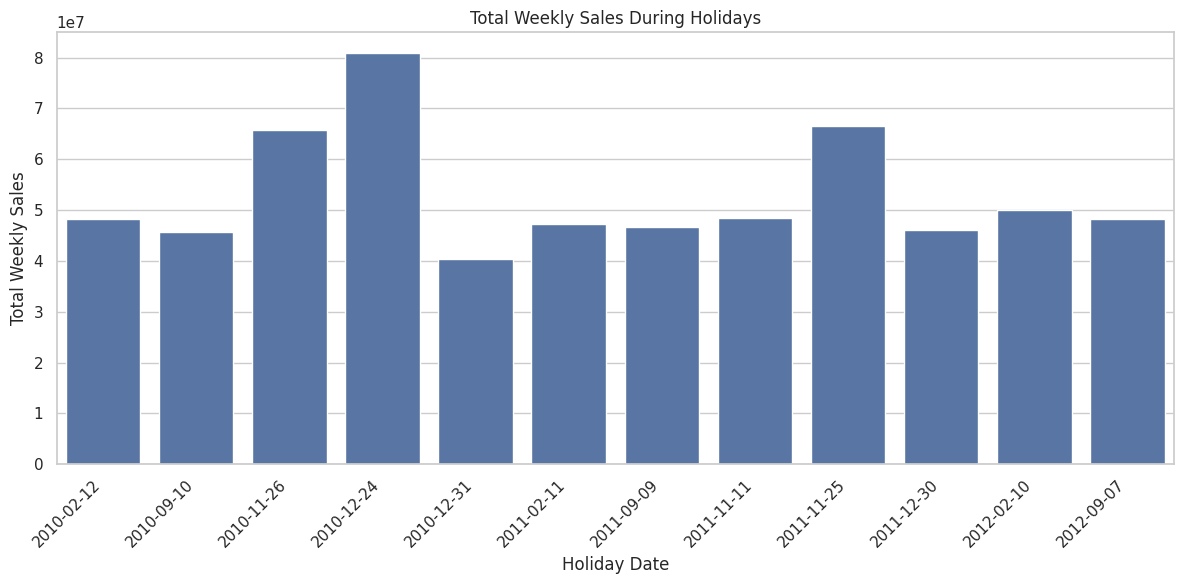

In [40]:
# bar graph of weekly sales among holidays

# Filter data for holiday weeks
holiday_sales = walmart_df[walmart_df['IsHoliday'] == True]

# Group by date and sum weekly sales
holiday_sales_by_date = holiday_sales.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Date', y='Weekly_Sales', data=holiday_sales_by_date)
plt.title('Total Weekly Sales During Holidays')
plt.xlabel('Holiday Date')
plt.ylabel('Total Weekly Sales')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

It seems like Christmas holidays had the most sales compared to the other holidays. Now let's explore whether this was because of the holiday itself or just the period Christmas holiday fell in.

In [41]:
df = walmart_df.copy()
for holiday in holidays:
    holiday_dates = [
        pd.to_datetime(date)
        for date_pair in holiday["dates"]
        for date in set(date_pair.values())
    ]

    # Create a new column for this holiday
    df["Is" + holiday["name"].replace(" ", "").replace("'", "")] = df['Date'].isin(holiday_dates)

# Output the updated dataframe
print(df.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month',
       'Week', 'Day', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type',
       'Size', 'IsNewYearsDay', 'IsMartinLutherKingJr.Day', 'IsPresidentsDay',
       'IsMemorialDay', 'IsIndependenceDay', 'IsLaborDay', 'IsColumbusDay',
       'IsVeteransDay', 'IsThanksgivingDay', 'IsChristmasDay'],
      dtype='object')


Average sales on New Year's Days (Holiday): 13828.57059507524
Average sales on other days: 16048.562163901193


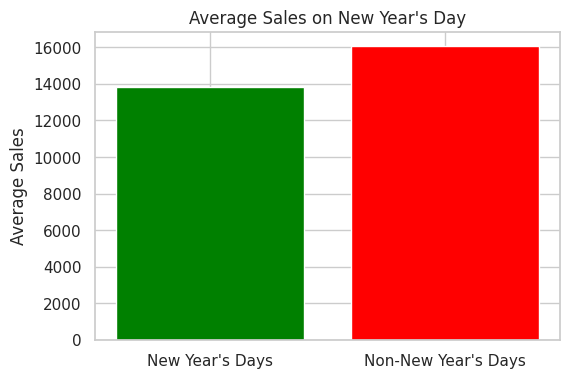

Average sales on Veterans Days (Holiday): 16376.445111486486
Average sales on other days: 16030.67899288679


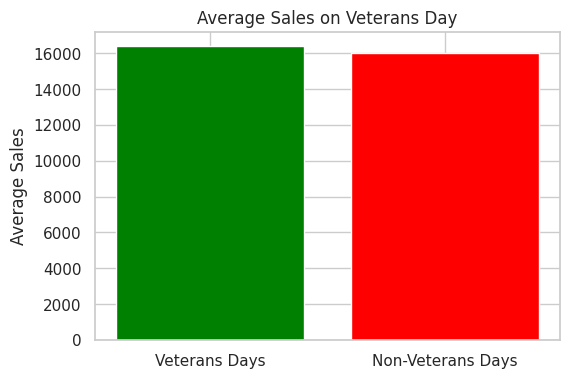

Average sales on Christmas Days (Holiday): 27415.848983739837
Average sales on other days: 15952.58486907444


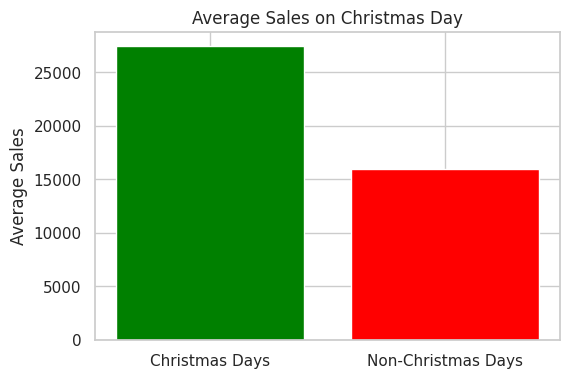

In [42]:
for holiday in holidays:

    # Separate the holiday sales and non-holiday sales
    holiday_column_name = "Is" + holiday["name"].replace(" ", "").replace("'", "")
    holiday_sales = df[df[holiday_column_name] == True]['Weekly_Sales']
    non_holiday_sales = df[df[holiday_column_name] == False]['Weekly_Sales']


    # Calculate the average sales
    avg_holiday_sales = holiday_sales.mean()
    avg_other_sales = non_holiday_sales.mean()

    if pd.isna(avg_holiday_sales):
      continue
    print(f"Average sales on {holiday['name']+'s'} (Holiday): {avg_holiday_sales}")
    print(f"Average sales on other days: {avg_other_sales}")
    # Create a bar plot for each holiday
    plt.figure(figsize=(6, 4))
    plt.bar([holiday["name"]+'s', 'Non-'+holiday['name']+'s'], [avg_holiday_sales, avg_other_sales], color=['green', 'red'])
    plt.title(f'Average Sales on {holiday["name"]}')
    plt.ylabel('Average Sales')
    plt.show()

From these graphs we can see that for Christmas and Veterans holidays there were more average sales on the day of these holiday than on all other days combined. Christmas day had the largest average sales relative to non-Christmas days, compared to other holidays.

Now we want to see if the month of December also had high sales or just Christmas day, Christmas eve, and Christmas-observe days.

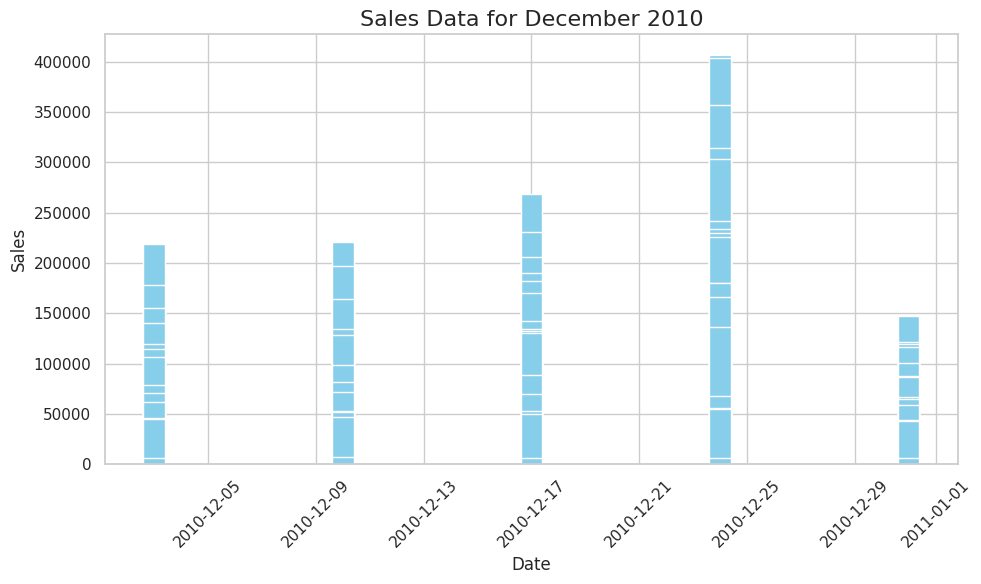

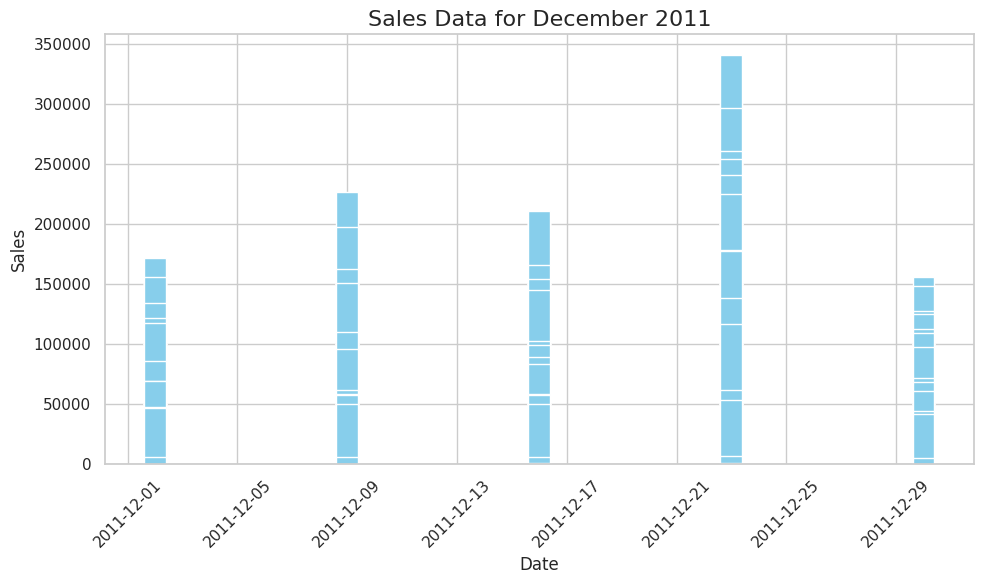

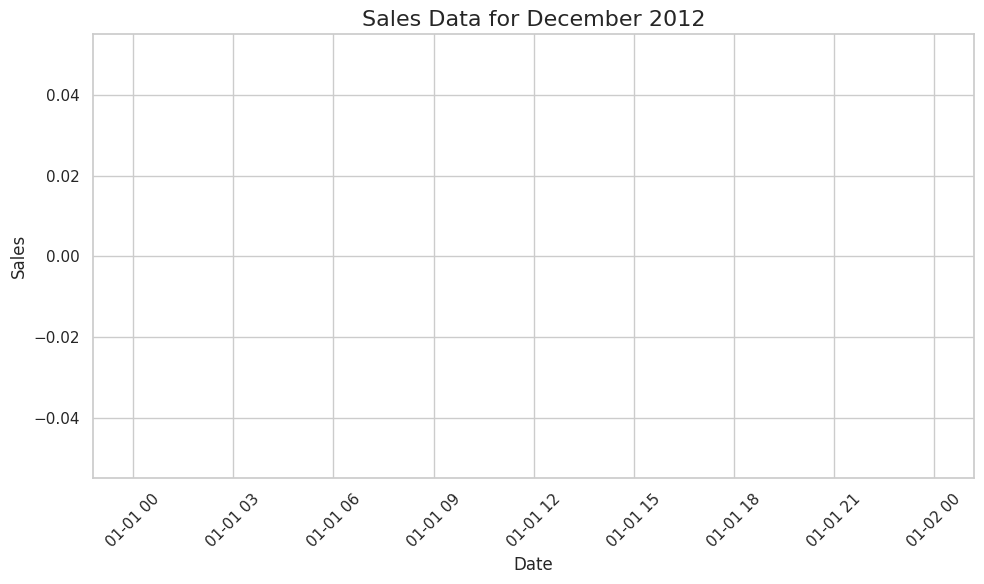

In [43]:
# Filter for dates in December for the years 2010, 2011, and 2012
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month


years = [2010, 2011, 2012]

for year in years:

  df_december = df[(df['Month'] == 12) & df['Year'].isin([year])]

  # Plotting a bar graph
  plt.figure(figsize=(10, 6))

  # Bar plot, using the 'Date' as the x-axis and 'Sales' as the y-axis
  plt.bar(df_december['Date'], df_december['Weekly_Sales'], color='skyblue')

  # Adding labels and title
  plt.title(f'Sales Data for December {year}', fontsize=16)
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('Sales', fontsize=12)

  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45)

  # Show gridlines to make the graph easier to read
  plt.grid(True)

  # Show the plot
  plt.tight_layout()
  plt.show()

We can see from the first two above bar charts that indeed the day of Christmas was correlated with the high amount of sales in December, rather than the month itself (even though relative to other months, December had high sales)

## Further Data Analysis


<ipython-input-44-8bad807f5a5f>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




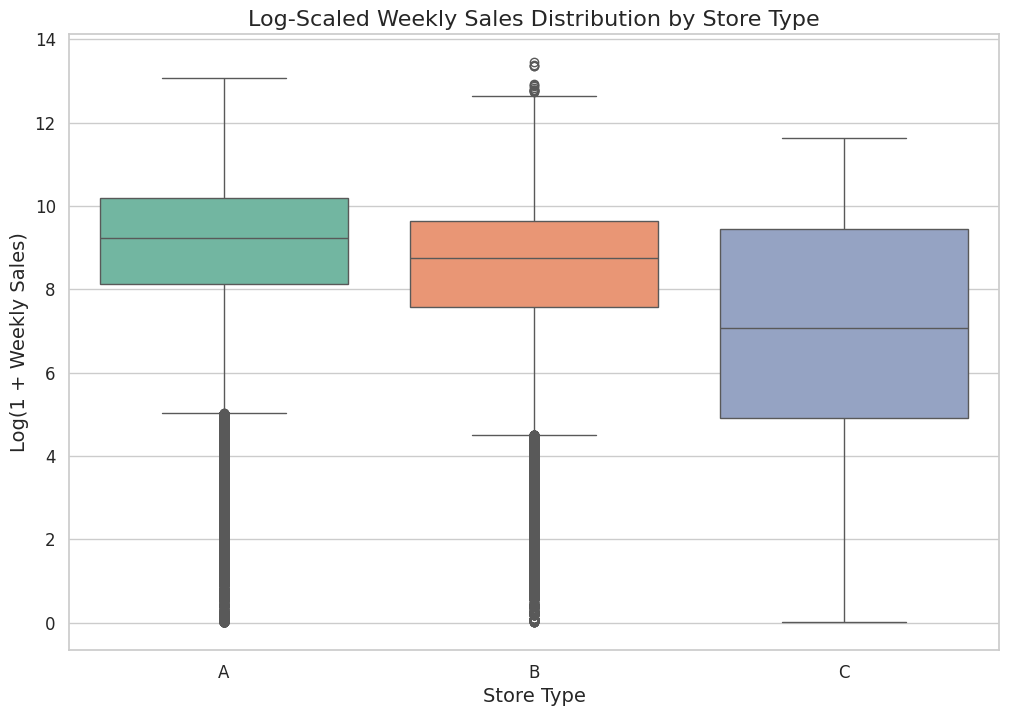

In [44]:
import numpy as np
# Analyze the relationship between sales and store size/type
walmart_df['Log_Weekly_Sales'] = np.log1p(walmart_df['Weekly_Sales'])

plt.figure(figsize=(12, 8))
sns.boxplot(x='Type', y='Log_Weekly_Sales', data=walmart_df, palette="Set2")
plt.title('Log-Scaled Weekly Sales Distribution by Store Type', fontsize=16)
plt.xlabel('Store Type', fontsize=14)
plt.ylabel('Log(1 + Weekly Sales)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


We can see that that Store Type A had more median sales than Type B, which in turn had more median sales than Type C

In [45]:
walmart_df.head()

Store  Dept       Date  Weekly_Sales IsHoliday  Year  Month  Week  Day  \
0      1     1 2010-02-05      24924.50         0  2010      2     5    5   
1      1     1 2010-02-12      46039.49         1  2010      2     6   12   
2      1     1 2010-02-19      41595.55         0  2010      2     7   19   
3      1     1 2010-02-26      19403.54         0  2010      2     8   26   
4      1     1 2010-03-05      21827.90         0  2010      3     9    5   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0        42.31       2.572        0.0        0.0        0.0        0.0   
1        38.51       2.548        0.0        0.0        0.0        0.0   
2        39.93       2.514        0.0        0.0        0.0        0.0   
3        46.63       2.561        0.0        0.0        0.0        0.0   
4        46.50       2.625        0.0        0.0        0.0        0.0   

   MarkDown5         CPI  Unemployment Type    Size  Log_Weekly_Sales  
0        0.0  211.096358         8.106    A  151315         10.123647  
1        0.0  211.242170         8.106    A  151315         10.737277  
2        0.0  211.289143         8.106    A  151315         10.635773  
3        0.0  211.319643         8.106    A  151315          9.873262  
4        0.0  211.350143         8.106    A  151315          9.990990

<ipython-input-46-871ba537d2ad>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




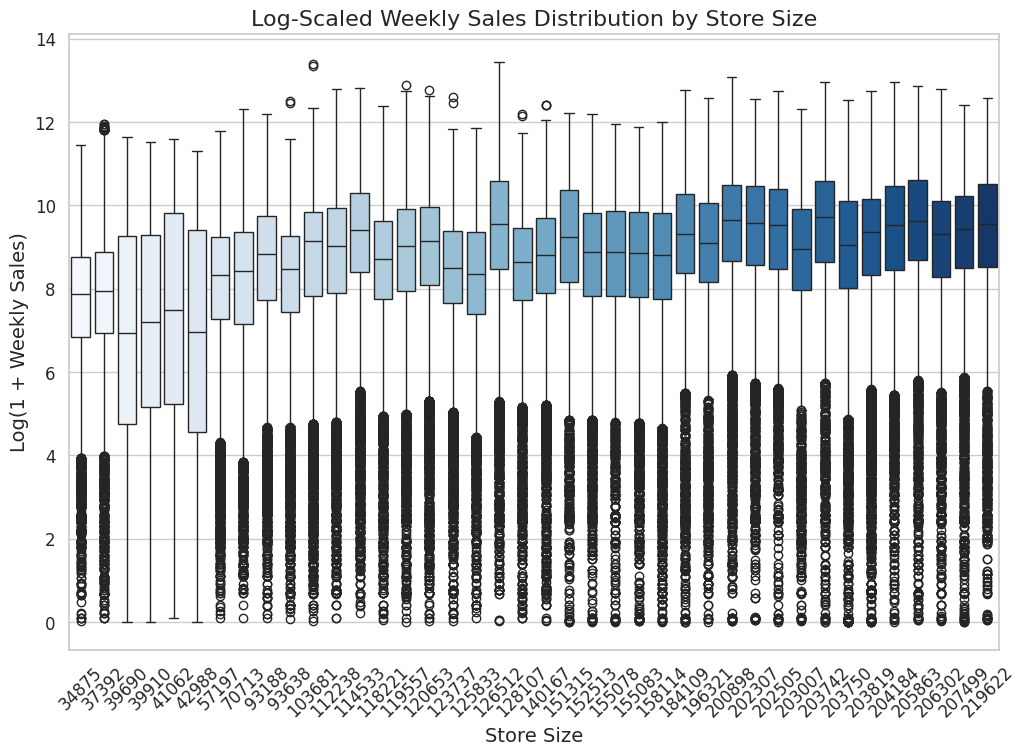

In [46]:
# Analyze sales trends for different store sizes
plt.figure(figsize=(12, 8))
sns.boxplot(x='Size', y='Log_Weekly_Sales', data=walmart_df, palette="Blues")
plt.title('Log-Scaled Weekly Sales Distribution by Store Size', fontsize=16)
plt.xlabel('Store Size', fontsize=14)
plt.ylabel('Log(1 + Weekly Sales)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()


Here we notice that as the store size increases, so does the number of weekly sales for that store

<ipython-input-47-cd9e58a248af>:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




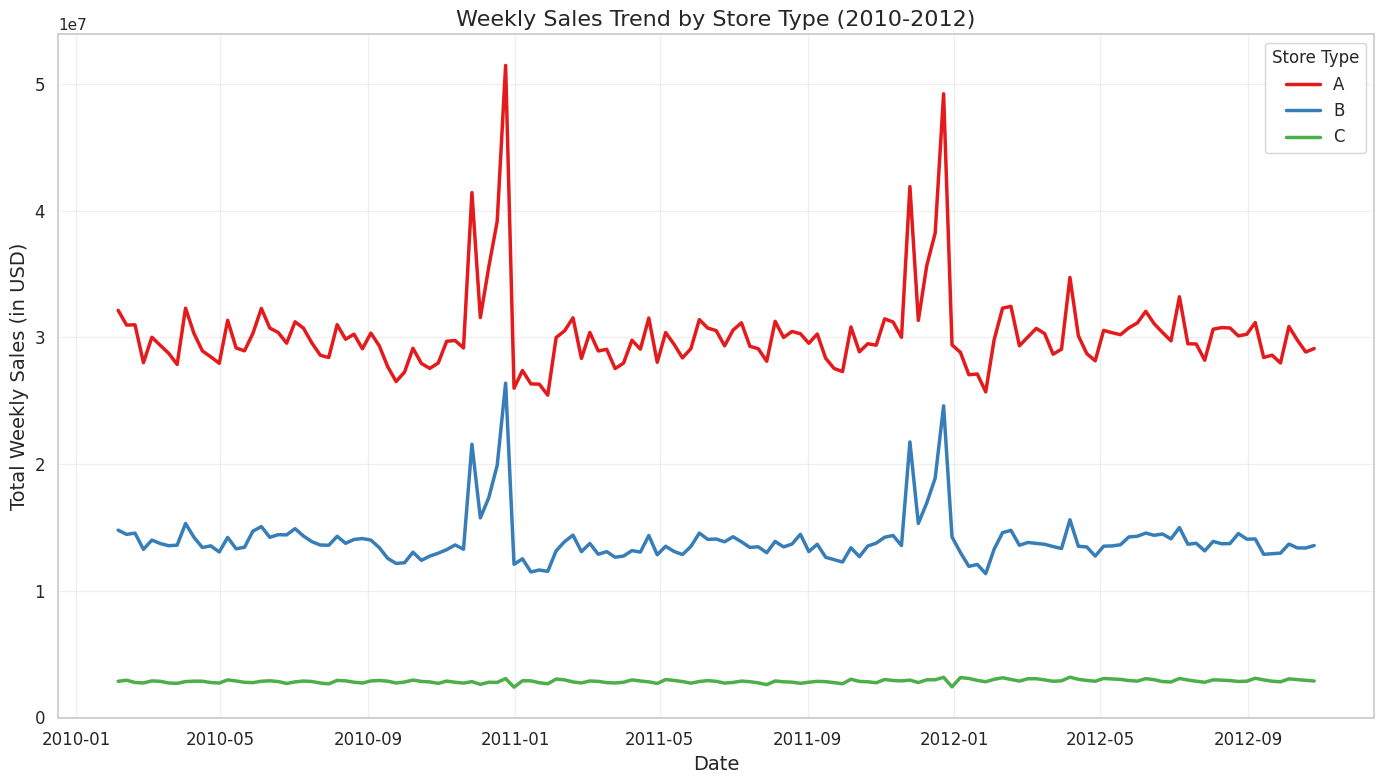

In [47]:
# Analyze sales trends for different store types
import matplotlib.pyplot as plt
import seaborn as sns

# Manually aggregate data for more control (if needed)
sales_by_type_date = (
    walmart_df.groupby(['Type', 'Date'])['Weekly_Sales']
    .sum()
    .reset_index()
)

# Plot using Seaborn for better aesthetics
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=sales_by_type_date,
    x='Date',
    y='Weekly_Sales',
    hue='Type',
    palette='Set1',
    linewidth=2.5,
    ci=None  # No confidence interval if not needed
)

# Additional customization
plt.title('Weekly Sales Trend by Store Type (2010-2012)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Weekly Sales (in USD)', fontsize=14)
plt.legend(title='Store Type', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Prevent overlap
plt.show()


We can clearly see about that weekly sales were seasonal, the highest being around December, and that Store Type A had more sales throughout than Type B which in turn was higher than Type C's sales

In [48]:
print(walmart_df.head())


   Store  Dept       Date  Weekly_Sales IsHoliday  Year  Month  Week  Day  \
0      1     1 2010-02-05      24924.50         0  2010      2     5    5   
1      1     1 2010-02-12      46039.49         1  2010      2     6   12   
2      1     1 2010-02-19      41595.55         0  2010      2     7   19   
3      1     1 2010-02-26      19403.54         0  2010      2     8   26   
4      1     1 2010-03-05      21827.90         0  2010      3     9    5   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0        42.31       2.572        0.0        0.0        0.0        0.0   
1        38.51       2.548        0.0        0.0        0.0        0.0   
2        39.93       2.514        0.0        0.0        0.0        0.0   
3        46.63       2.561        0.0        0.0        0.0        0.0   
4        46.50       2.625        0.0        0.0        0.0        0.0   

   MarkDown5         CPI  Unemployment Type    Size  Log_Weekly_Sales  
0        0.0  211.09

In [49]:
# Ensure 'Date' is in datetime format
walmart_df['Date'] = pd.to_datetime(walmart_df['Date'], errors='coerce')

# Extract 'Month' and 'Year' from 'Date'
walmart_df['Month'] = walmart_df['Date'].dt.month
walmart_df['Year'] = walmart_df['Date'].dt.year
# Check if the column was added successfully
print(walmart_df[['Date', 'Year']].head())

        Date  Year
0 2010-02-05  2010
1 2010-02-12  2010
2 2010-02-19  2010
3 2010-02-26  2010
4 2010-03-05  2010


<ipython-input-50-8adcb56c2260>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




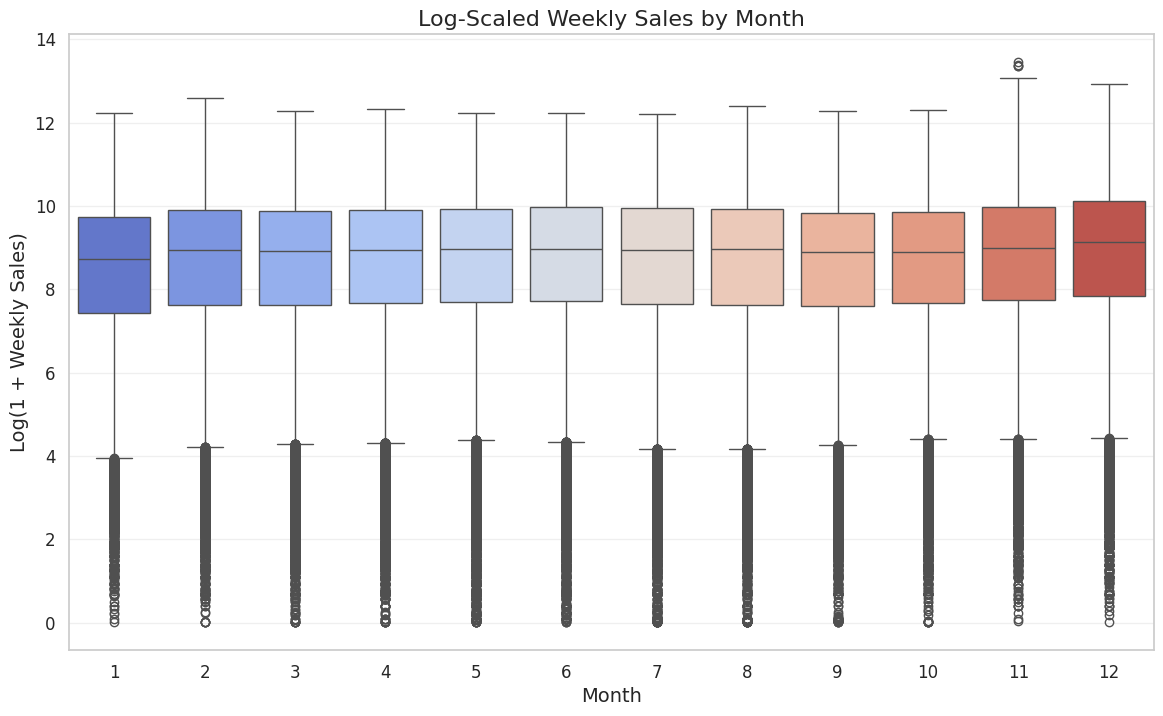

In [50]:
# Analyze Sales by Month (Log-scaled)

plt.figure(figsize=(14, 8))
sns.boxplot(x='Month', y='Log_Weekly_Sales', data=walmart_df, palette="coolwarm")
plt.title('Log-Scaled Weekly Sales by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Log(1 + Weekly Sales)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

Weekly sales are lowest at the beginning of the year (January - April), roughly consistent during the middle of the year (May - August), and highest towards the end of the year (September - December)

<ipython-input-51-d5115d7e273d>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




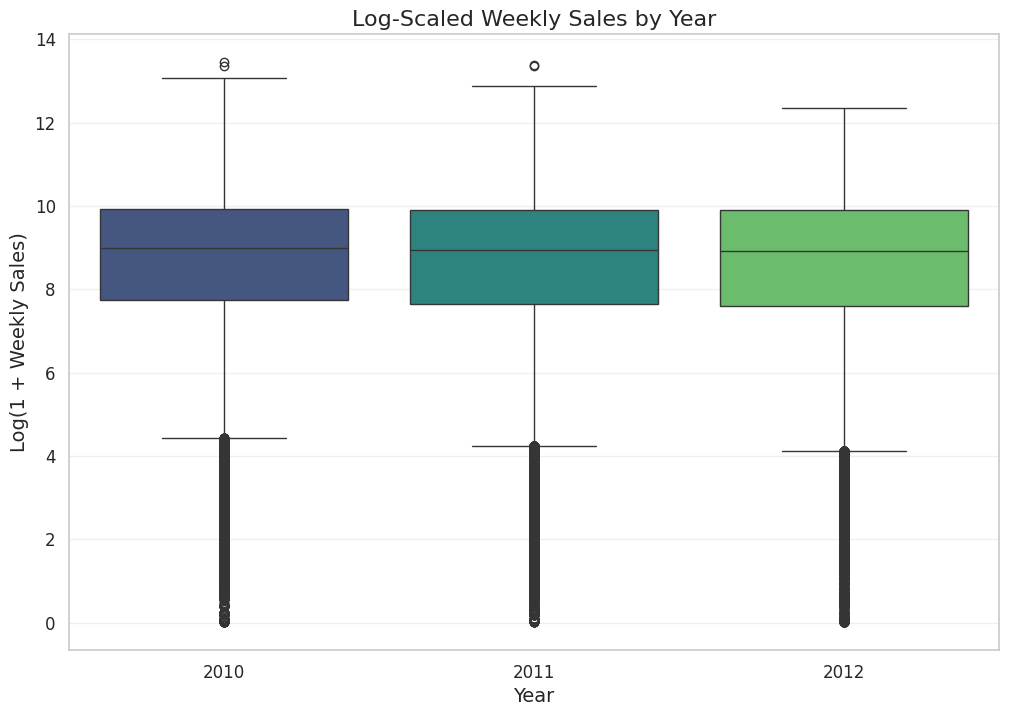

In [51]:
# Analyze Sales by Year (Log-scaled)
plt.figure(figsize=(12, 8))
sns.boxplot(x='Year', y='Log_Weekly_Sales', data=walmart_df, palette="viridis")
plt.title('Log-Scaled Weekly Sales by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Log(1 + Weekly Sales)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()


Seems like 2010 had the most sales

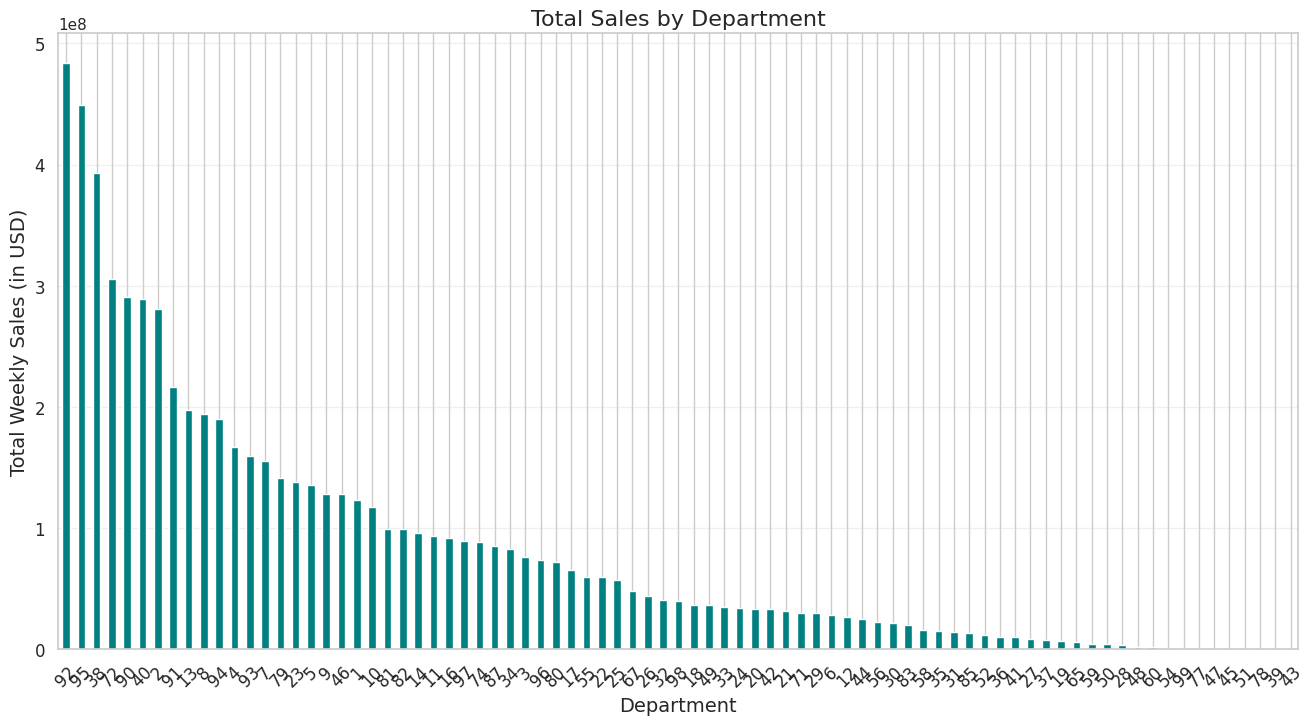

In [52]:
# Analyze sales by department
dept_sales = walmart_df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(16, 8))
dept_sales.plot(kind='bar', color='teal')
plt.title('Total Sales by Department', fontsize=16)
plt.xlabel('Department', fontsize=14)
plt.ylabel('Total Weekly Sales (in USD)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [53]:
walmart_df.head()

Store  Dept       Date  Weekly_Sales IsHoliday  Year  Month  Week  Day  \
0      1     1 2010-02-05      24924.50         0  2010      2     5    5   
1      1     1 2010-02-12      46039.49         1  2010      2     6   12   
2      1     1 2010-02-19      41595.55         0  2010      2     7   19   
3      1     1 2010-02-26      19403.54         0  2010      2     8   26   
4      1     1 2010-03-05      21827.90         0  2010      3     9    5   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0        42.31       2.572        0.0        0.0        0.0        0.0   
1        38.51       2.548        0.0        0.0        0.0        0.0   
2        39.93       2.514        0.0        0.0        0.0        0.0   
3        46.63       2.561        0.0        0.0        0.0        0.0   
4        46.50       2.625        0.0        0.0        0.0        0.0   

   MarkDown5         CPI  Unemployment Type    Size  Log_Weekly_Sales  
0        0.0  211.096358         8.106    A  151315         10.123647  
1        0.0  211.242170         8.106    A  151315         10.737277  
2        0.0  211.289143         8.106    A  151315         10.635773  
3        0.0  211.319643         8.106    A  151315          9.873262  
4        0.0  211.350143         8.106    A  151315          9.990990

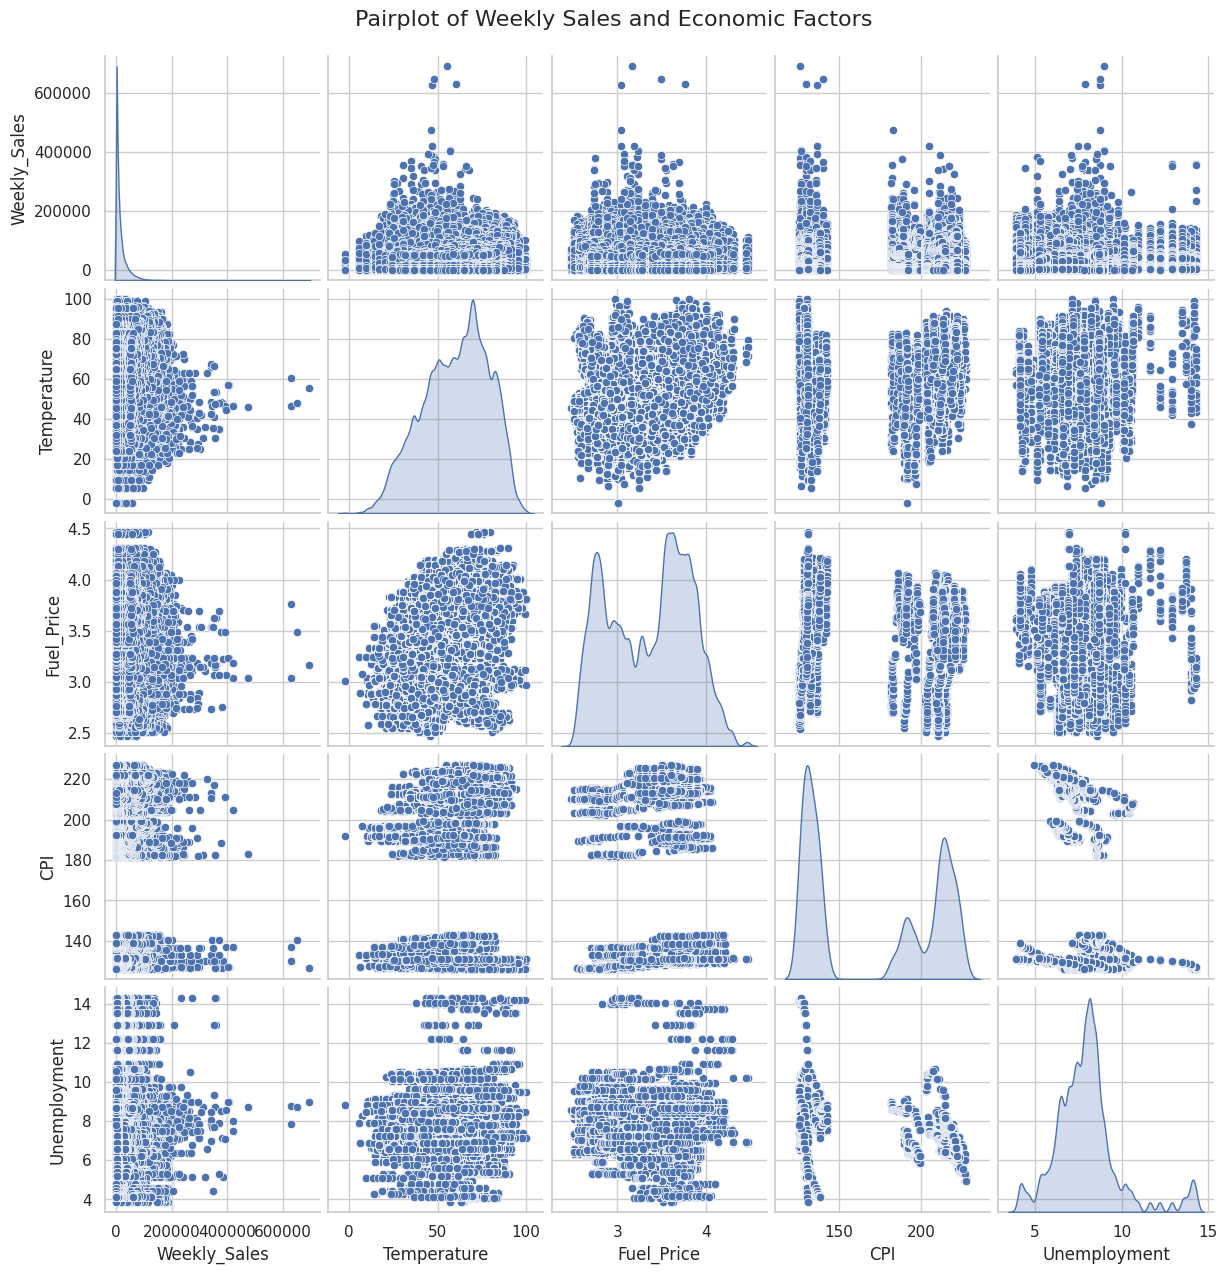

In [54]:
# Explore relationships between features using pairplots
sns.pairplot(walmart_df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']],
             diag_kind='kde')
plt.suptitle("Pairplot of Weekly Sales and Economic Factors", y=1.02, fontsize=16)
plt.show()

## Model Implementation and Evaluation

In [55]:
walmart_df.head()

Store  Dept       Date  Weekly_Sales IsHoliday  Year  Month  Week  Day  \
0      1     1 2010-02-05      24924.50         0  2010      2     5    5   
1      1     1 2010-02-12      46039.49         1  2010      2     6   12   
2      1     1 2010-02-19      41595.55         0  2010      2     7   19   
3      1     1 2010-02-26      19403.54         0  2010      2     8   26   
4      1     1 2010-03-05      21827.90         0  2010      3     9    5   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0        42.31       2.572        0.0        0.0        0.0        0.0   
1        38.51       2.548        0.0        0.0        0.0        0.0   
2        39.93       2.514        0.0        0.0        0.0        0.0   
3        46.63       2.561        0.0        0.0        0.0        0.0   
4        46.50       2.625        0.0        0.0        0.0        0.0   

   MarkDown5         CPI  Unemployment Type    Size  Log_Weekly_Sales  
0        0.0  211.096358         8.106    A  151315         10.123647  
1        0.0  211.242170         8.106    A  151315         10.737277  
2        0.0  211.289143         8.106    A  151315         10.635773  
3        0.0  211.319643         8.106    A  151315          9.873262  
4        0.0  211.350143         8.106    A  151315          9.990990

In [56]:
# Aggregate sales by date (across all stores)
total_daily_sales = walmart_df.groupby('Date')[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'Year']].first().reset_index()
# Display the aggregated DataFrame
print(total_daily_sales.head())

        Date  Weekly_Sales  Temperature  Fuel_Price         CPI  Unemployment  \
0 2010-02-05      24924.50        42.31       2.572  211.096358         8.106   
1 2010-02-12      46039.49        38.51       2.548  211.242170         8.106   
2 2010-02-19      41595.55        39.93       2.514  211.289143         8.106   
3 2010-02-26      19403.54        46.63       2.561  211.319643         8.106   
4 2010-03-05      21827.90        46.50       2.625  211.350143         8.106   

  IsHoliday  Month  Year  
0         0      2  2010  
1         1      2  2010  
2         0      2  2010  
3         0      2  2010  
4         0      3  2010  




### Autoregressive Models (Jibraan)

AR models are time series models that depend on past data and its stability to predict future sales results. This model serves as an effective baseline as it does not yet account for seasonality. AR models are typically dependent on stationairty and data that is as holiday dependent as ours may not converge well with this type of model.

RMSE of Autoregressive model: 7124.0597145900165
MAPE of Autoregressive model: 31.77%


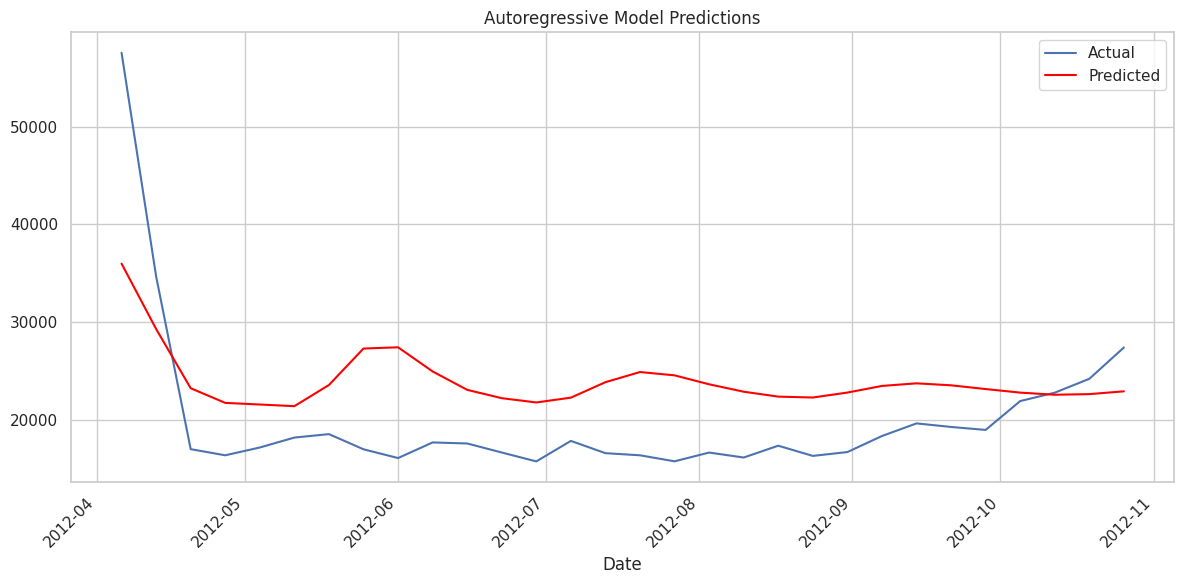

In [57]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the time series data
# Assuming 'walmart_df' is your DataFrame and 'Weekly_Sales' is your target variable
# and it's already sorted by date.
timeseries = total_daily_sales['Weekly_Sales'].values

# Split data into training and testing sets (adjust as needed)
train_data = timeseries[:-30]
test_data = timeseries[-30:]

# Train the autoregressive model
# 'lags' is the number of previous time steps to consider (experiment with different values)
model = AutoReg(train_data, lags=7) # Example, you might need more lags
model_fit = model.fit()


# Make predictions on the test data
predictions = model_fit.predict(start=len(train_data), end=len(timeseries)-1, dynamic=False)

# Evaluate the model (e.g., using RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"RMSE of Autoregressive model: {rmse}")
mape = np.mean(np.abs((test_data - predictions) / np.where(test_data != 0, test_data, 1))) * 100

print(f"MAPE of Autoregressive model: {mape:.2f}%") # Print with 2 decimal places

# Get the dates for the test data period
test_dates = total_daily_sales['Date'][-30:]  # Assuming 'Date' column in total_daily_sales

#Plot the predictions against actual values with dates on x-axis
plt.figure(figsize=(12,6))
plt.plot(test_dates, test_data, label='Actual')
plt.plot(test_dates, predictions, label='Predicted', color='red')
plt.legend()
plt.title("Autoregressive Model Predictions")
plt.xlabel("Date")  # Add x-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

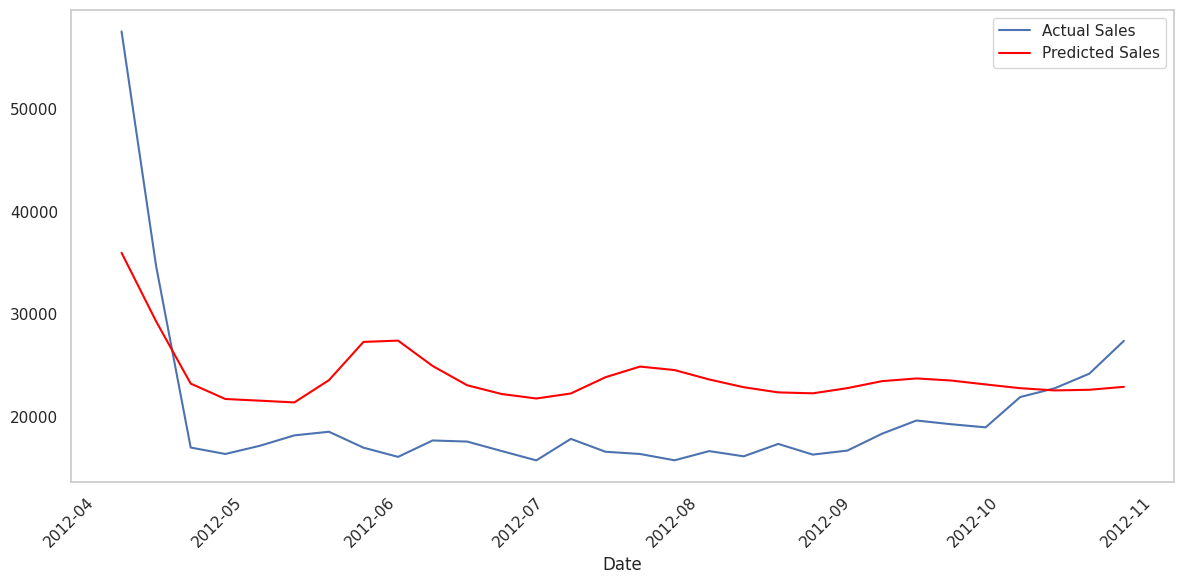

In [58]:
#Plot the predictions against actual values with dates on x-axis
plt.figure(figsize=(12,6))
plt.plot(test_dates, test_data, label='Actual Sales')
plt.plot(test_dates, predictions, label='Predicted Sales', color='red')
plt.legend()
# plt.title("Autoregressive Model Predictions")
plt.xlabel("Date")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(False)
plt.show()

--

In [59]:
# this is for random forests later
test_df_rf = test_df.copy()
train_df_rf = train_df.copy()

# Prophet Model (Jibraan)

Prohpet is built on a similar idea of that of Autoregression. However, it is designed to capture seasanolity, holiday spikes, and non-stationairty through thungs like inflation, unemployment changes, and fuel price changes. It gives individual datapoint predictions by splitting the data into components and relying on previous values only within components for predictions of datpoints in the same component.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppyh1qr89/yw2565ji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppyh1qr89/mzvd4s1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48433', 'data', 'file=/tmp/tmppyh1qr89/yw2565ji.json', 'init=/tmp/tmppyh1qr89/mzvd4s1q.json', 'output', 'file=/tmp/tmppyh1qr89/prophet_model75b4jcr7/prophet_model-20241209153528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


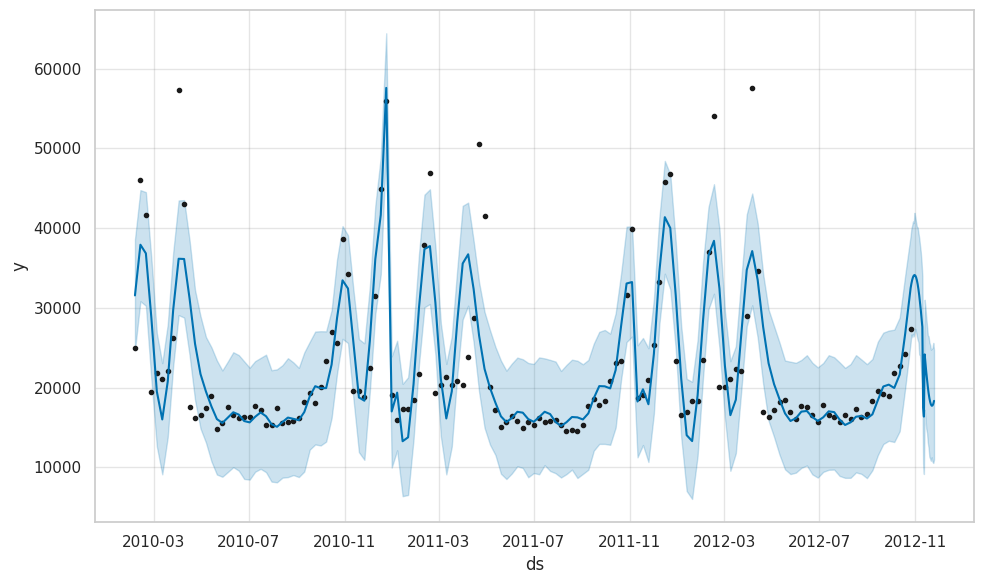

In [60]:
!pip install prophet

import pandas as pd
from prophet import Prophet

# 'holidays' is our list of holidays

# 1. Create a DataFrame for Prophet using original data
df_prophet = pd.DataFrame({'ds': total_daily_sales['Date'],
                           'y': total_daily_sales['Weekly_Sales']})

# 2. Create a holiday DataFrame for Prophet
holidays_df = pd.DataFrame()
for holiday in holidays:
    for date_pair in holiday['dates']:
        for date_type in ["actual", "observed"]:
            holiday_date = pd.to_datetime(date_pair[date_type])
            holidays_df = pd.concat([holidays_df, pd.DataFrame({'holiday': holiday['name'], 'ds': [holiday_date]})], ignore_index=True)

# 3. Initialize and fit the Prophet model with holidays
model_prophet = Prophet(holidays=holidays_df)
model_prophet.fit(df_prophet)

# 4. Create a future DataFrame for forecasting
future = model_prophet.make_future_dataframe(periods=30)

# 5. Make predictions
forecast = model_prophet.predict(future)

# 6. Plot the forecast
fig = model_prophet.plot(forecast)

In [61]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_prophet, test_size=0.2, shuffle=False)  # shuffle=False for time series

# Fit the model on the training data
model_prophet = Prophet(holidays=holidays_df)
model_prophet.fit(train_df)

# Make predictions on the test data using the same 'ds' values
forecast = model_prophet.predict(test_df[['ds']])  # Use only 'ds' for prediction

# Reset index of test_df and forecast to align them
test_df = test_df.reset_index(drop=True)
forecast = forecast.reset_index(drop=True)


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = test_df['y']  # Actual values
y_pred = forecast['yhat']  # Predicted values

rmse = mean_squared_error(y_true, y_pred, squared=False)  # squared=False for RMSE
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Calculate MAPE
y_true_no_zeros = np.where(y_true == 0, 1e-10, y_true)
mape = np.mean(np.abs((y_true - y_pred) / y_true_no_zeros)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppyh1qr89/rq91hyp5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppyh1qr89/fzwscvcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64539', 'data', 'file=/tmp/tmppyh1qr89/rq91hyp5.json', 'init=/tmp/tmppyh1qr89/fzwscvcb.json', 'output', 'file=/tmp/tmppyh1qr89/prophet_modelyawr5_8h/prophet_model-20241209153529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:35:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 4184.910171423388
MAE: 2338.915690442863
MAPE: 12.707735496533179
R2: -0.08478412987007933


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



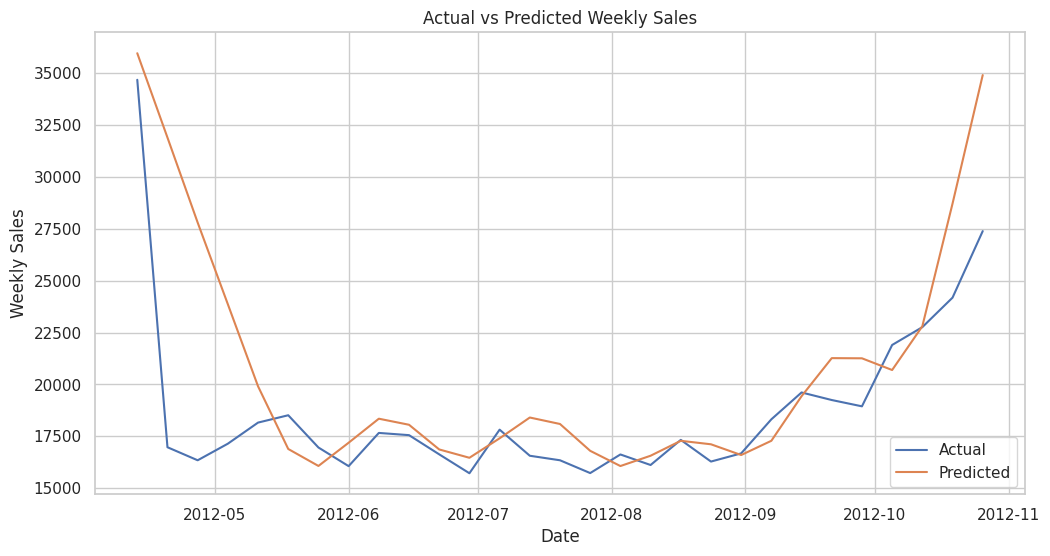

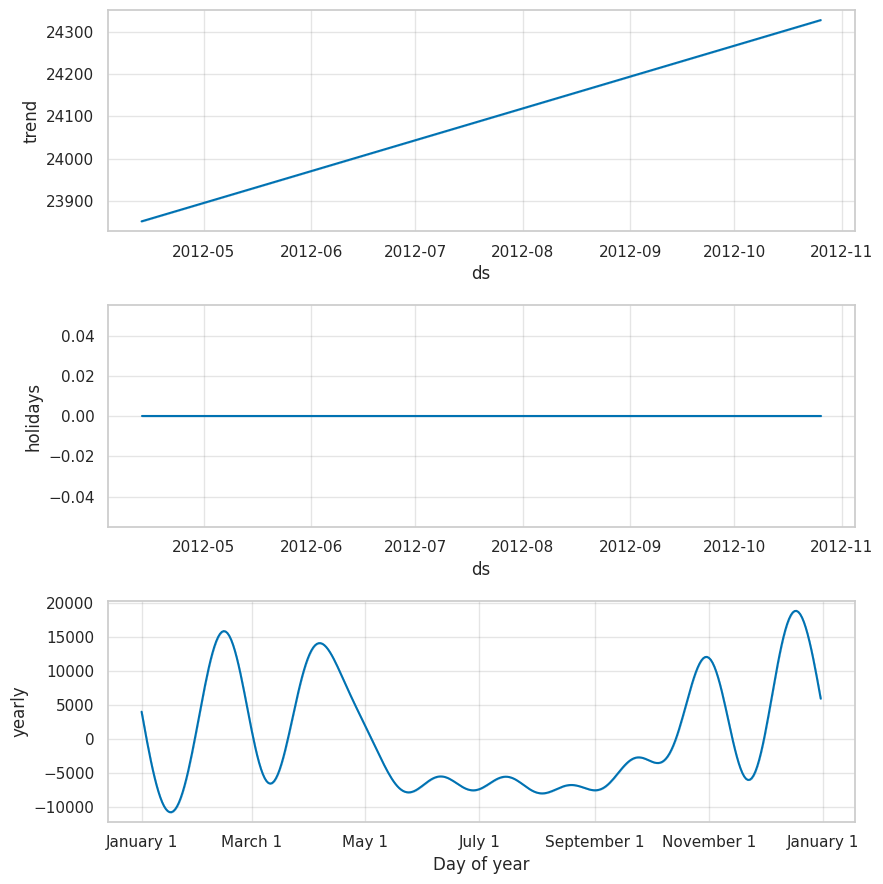

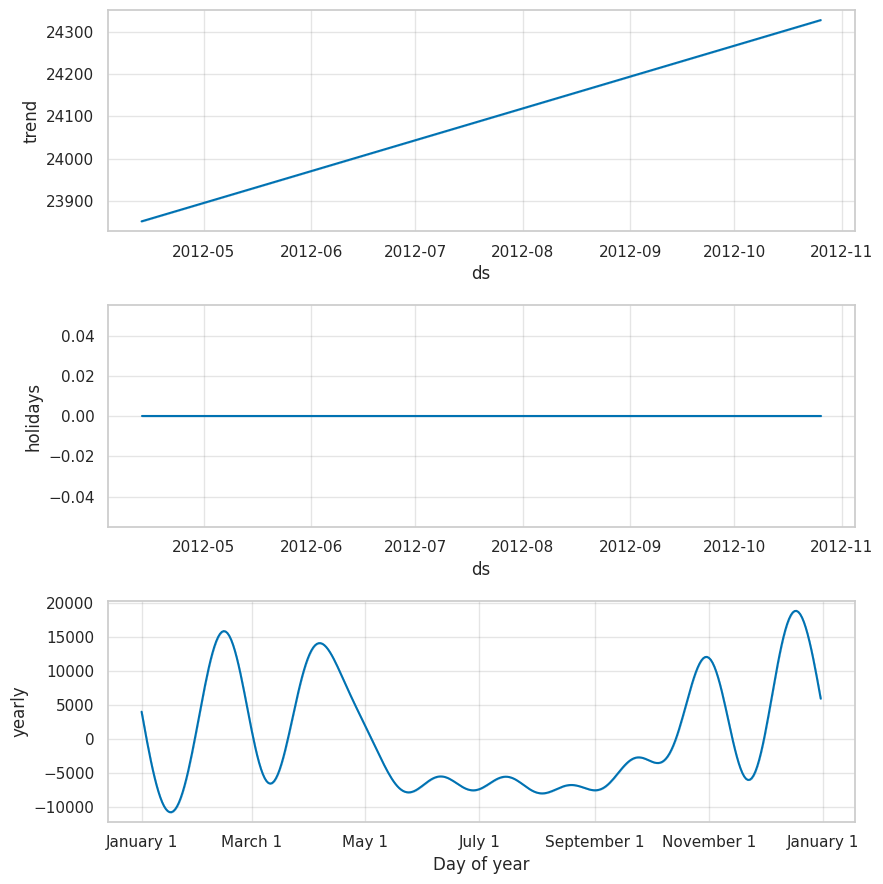

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_true, label='Actual')
plt.plot(test_df['ds'], y_pred, label='Predicted')
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

# Prophet's built-in plot for components
model_prophet.plot_components(forecast)

### Gradient-Boosting (Wan and Jibraan)

In [63]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = total_daily_sales[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'Year']].copy()
y = total_daily_sales['Weekly_Sales']

# Convert boolean 'IsHoliday' to numerical
X['IsHoliday'] = X['IsHoliday'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],   # Specify training and validation datasets
    valid_names=['train', 'valid'],     # Optional names for datasets
    callbacks=[lgb.early_stopping(10)]    # Early stopping based on validation set
)

# Make predictions
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE of LightGBM model: {rmse}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 6
[LightGBM] [Info] Start training from score 22488.121839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

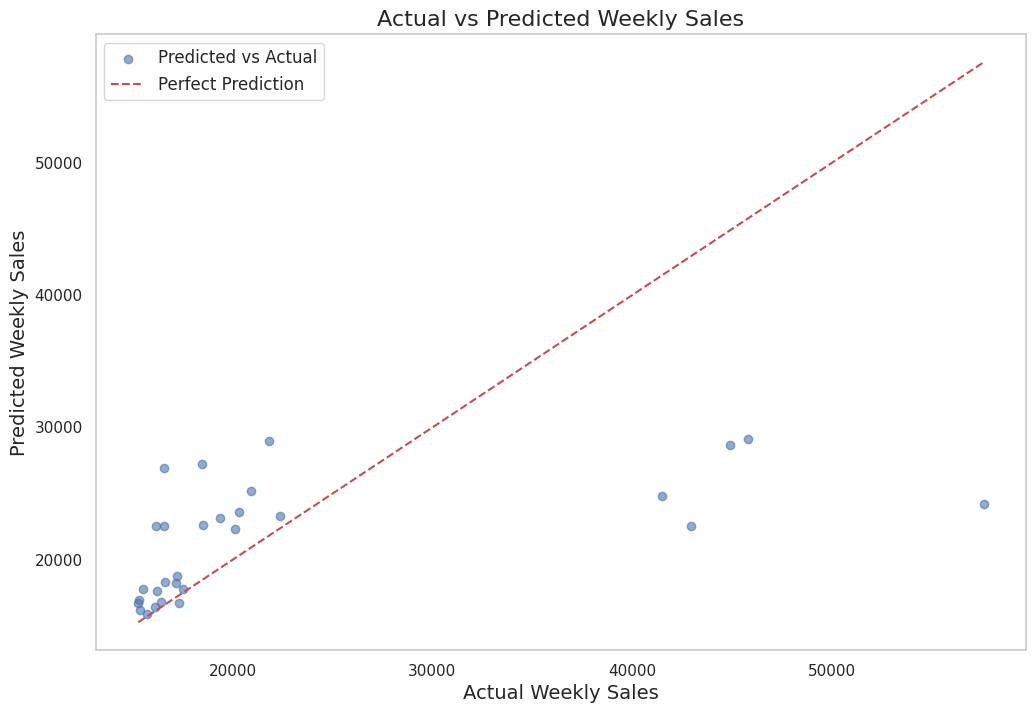

In [64]:
# Compare predicted vs actual values
plt.figure(figsize=(12, 8))

# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.6, color='b', label='Predicted vs Actual')

# Plot a line for perfect prediction
max_value = max(max(y_test), max(y_pred))
min_value = min(min(y_test), min(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='r', linestyle='--', label='Perfect Prediction')

# Add labels, legend, and title
plt.title('Actual vs Predicted Weekly Sales', fontsize=16)
plt.xlabel('Actual Weekly Sales', fontsize=14)
plt.ylabel('Predicted Weekly Sales', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Random Forest (Andrew)

In [65]:
# One-hot encode the Type column

train_df_rf = pd.get_dummies(train_df_rf, columns=['Type'])

In [66]:
test_df_rf = pd.get_dummies(test_df_rf, columns=['Type'])

In [67]:
train_columns = set(train_df_rf.columns)
test_columns = set(test_df_rf.columns)

missing_in_test = train_columns - test_columns
missing_in_train = test_columns - train_columns

print("Columns in train but not in test:", missing_in_test)
print("Columns in test but not in train:", missing_in_train)

Columns in train but not in test: {'Weekly_Sales'}
Columns in test but not in train: set()


In [68]:
features = [
    'Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
    'IsHoliday', 'Year', 'Month', 'Week', 'Day']


print("Columns in train:", train_df.columns.tolist())
print("Columns in features list:", features_df)
missing_columns = [col for col in features_df if col not in train_df.columns]
print("Missing columns in train:", missing_columns)

Columns in train: ['ds', 'y']
Columns in features list:       Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0         1 2010-02-05        42.31       2.572       0.00       0.00   
1         1 2010-02-12        38.51       2.548       0.00       0.00   
2         1 2010-02-19        39.93       2.514       0.00       0.00   
3         1 2010-02-26        46.63       2.561       0.00       0.00   
4         1 2010-03-05        46.50       2.625       0.00       0.00   
...     ...        ...          ...         ...        ...        ...   
8185     45 2013-06-28        76.05       3.639    4842.29     975.03   
8186     45 2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45 2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45 2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45 2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  Is

In [69]:
type_columns = [col for col in train_df_rf.columns if 'Type_' in col]
features.extend(type_columns)

In [70]:
missing_features = [f for f in features if f not in test_df_rf.columns]
if missing_features:
    print("The following features are missing in test data:", missing_features)


In [71]:
train = train_df_rf.sort_values('Date')

split_date = train['Date'].max() - pd.DateOffset(months=6)

X_train = train[train['Date'] < split_date]
X_valid = train[train['Date'] >= split_date]

print("Training data range:", X_train['Date'].min(), "to", X_train['Date'].max())
print("Validation data range:", X_valid['Date'].min(), "to", X_valid['Date'].max())


Training data range: 2010-02-05 00:00:00 to 2012-04-20 00:00:00
Validation data range: 2012-04-27 00:00:00 to 2012-10-26 00:00:00


In [72]:
missing_dates = pd.date_range(
    start=X_train['Date'].max() + pd.Timedelta(days=1),
    end=X_valid['Date'].min() - pd.Timedelta(days=1),
    freq='D'
)

print("Missing dates between training and validation:")
print(missing_dates)

Missing dates between training and validation:
DatetimeIndex(['2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26'],
              dtype='datetime64[ns]', freq='D')


In [73]:
print("Columns in X_valid:", X_valid.columns.tolist())
print("Columns in test:", test_df_rf.columns.tolist())
missing_columns_valid = [col for col in features if col not in X_valid.columns]
print("Missing columns in X_valid:", missing_columns_valid)

Columns in X_valid: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month', 'Week', 'Day', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Type_A', 'Type_B', 'Type_C']
Columns in test: ['Store', 'Dept', 'Date', 'IsHoliday', 'Year', 'Month', 'Week', 'Day', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Type_A', 'Type_B', 'Type_C']
Missing columns in X_valid: []


In [74]:
X_train = X_train.set_index('Date')
X_valid = X_valid.set_index('Date')
test_df_rf = test_df_rf.set_index('Date')

X_train_features = X_train[features]
y_train = X_train['Weekly_Sales']

X_valid_features = X_valid[features]
y_valid = X_valid['Weekly_Sales']

print("Is 'Date' in index of X_valid and test?")
print("X_valid index:", X_valid.index.name)
print("test index:", test_df_rf.index.name)

Is 'Date' in index of X_valid and test?
X_valid index: Date
test index: Date


In [75]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
n_estimators=100,
max_depth=None,
random_state=42,
n_jobs=-1
)

rf_model.fit(X_train_features, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = rf_model.predict(X_valid_features)

mae = mean_absolute_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

Validation MAE: 1674.69
Validation RMSE: 3424.10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [77]:
y_valid_mean = y_valid.mean()
y_valid_std = y_valid.std()

normalized_rmse = rmse / y_valid_mean

std_normalized_rmse = rmse / y_valid_std

# Display the results
print(f"Validation RMSE: {rmse:.2f}")
print(f"Normalized RMSE (by mean): {normalized_rmse:.2f}")
print(f"Normalized RMSE (by std): {std_normalized_rmse:.2f}")

Validation RMSE: 3424.10
Normalized RMSE (by mean): 0.22
Normalized RMSE (by std): 0.16


Feature Importances:
Dept            0.619176
Size            0.192633
Store           0.052646
Week            0.040630
CPI             0.027615
Unemployment    0.012529
Type_B          0.010699
Temperature     0.009872
Day             0.008804
MarkDown3       0.006472
Month           0.005972
Fuel_Price      0.004190
Type_A          0.003450
MarkDown4       0.001261
IsHoliday       0.001018
MarkDown5       0.000861
MarkDown2       0.000831
MarkDown1       0.000680
Type_C          0.000405
Year            0.000257
dtype: float64


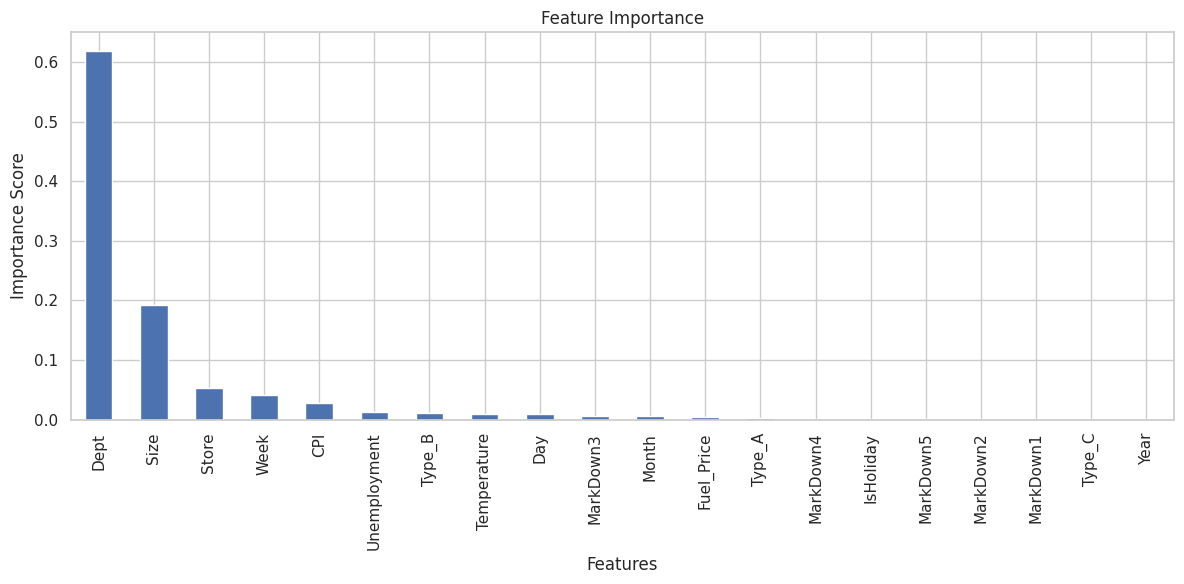

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

feature_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

print("Feature Importances:")
print(feature_importance)

plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

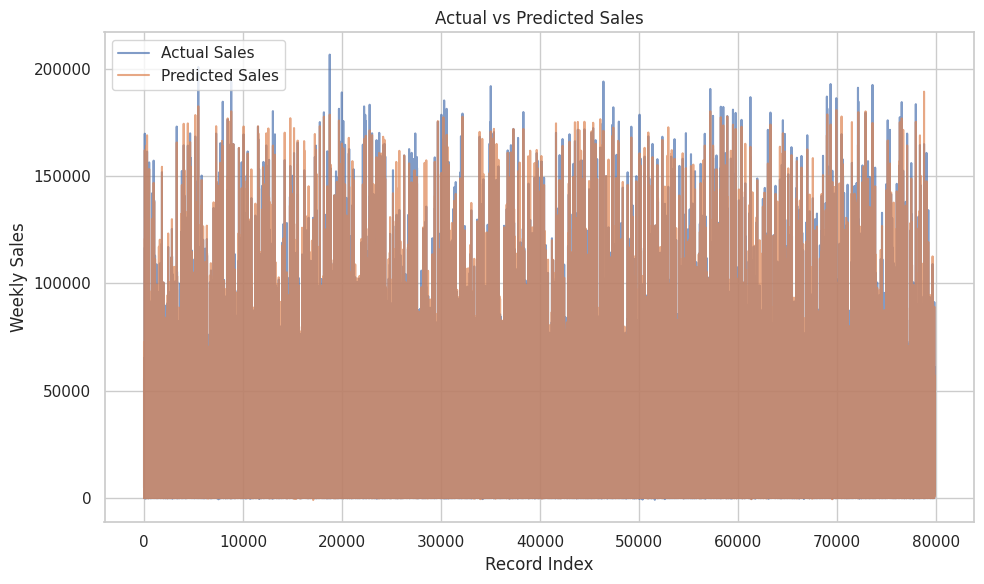

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(y_valid.values, label='Actual Sales', alpha=0.7)
plt.plot(y_pred, label='Predicted Sales', alpha=0.7)
plt.title('Actual vs Predicted Sales')
plt.ylabel('Weekly Sales')
plt.xlabel('Record Index')
plt.legend()
plt.tight_layout()
plt.show()

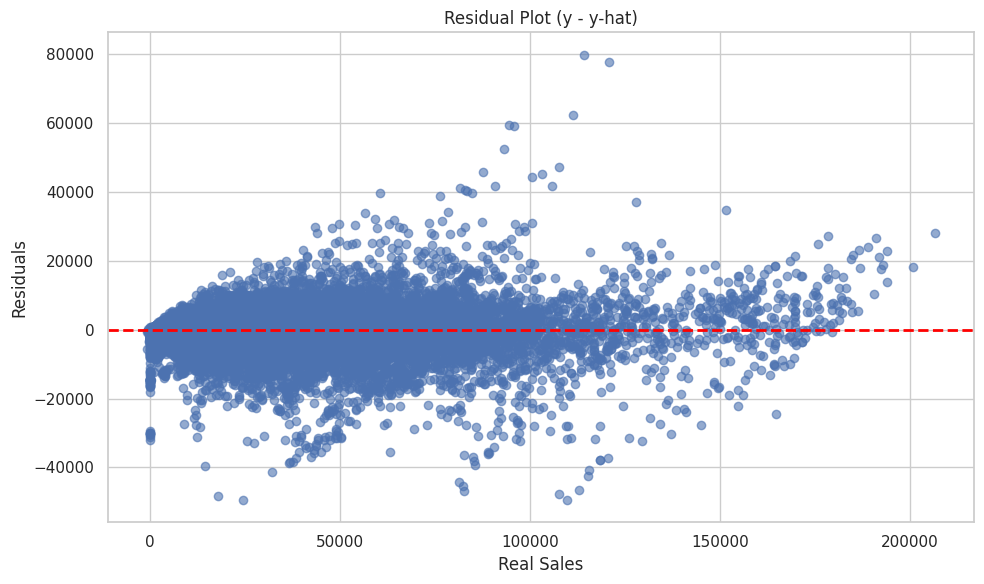

In [80]:
residuals = y_valid.values - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_valid.values, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot (y - y-hat)')
plt.xlabel('Real Sales')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


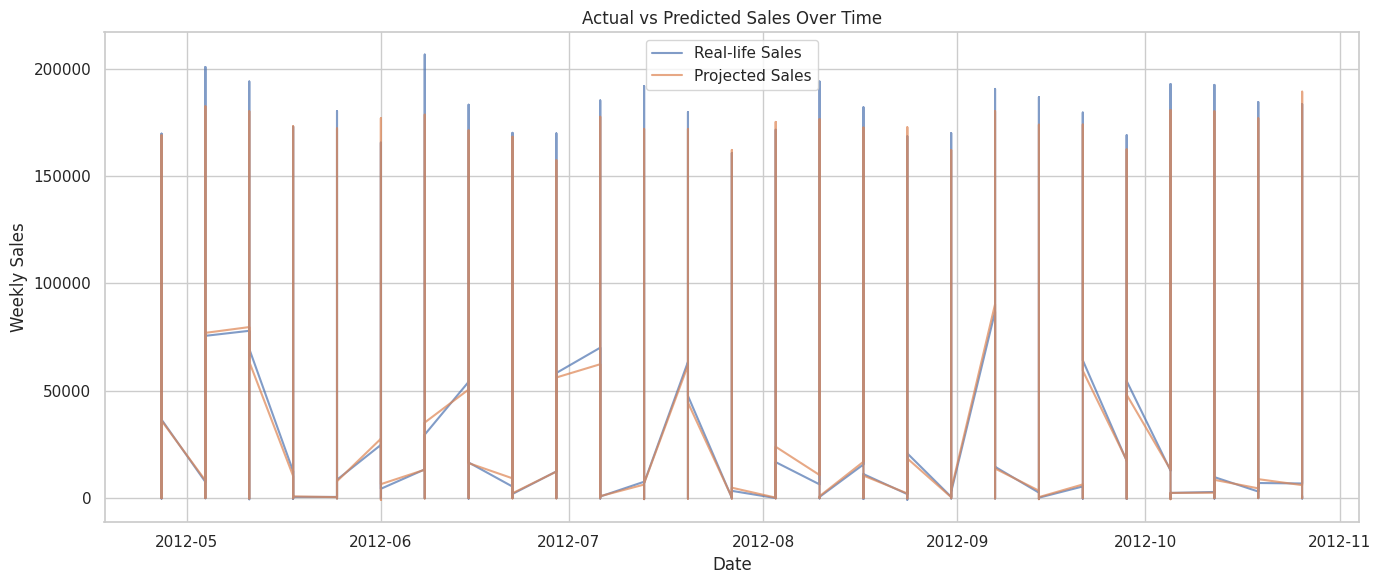

In [81]:
X_valid = X_valid.reset_index()
plt.figure(figsize=(14, 6))
plt.plot(X_valid['Date'], y_valid.values, label='Real-life Sales', alpha=0.7)
plt.plot(X_valid['Date'], y_pred, label='Projected Sales', alpha=0.7)
plt.title('Actual vs Predicted Sales Over Time')
plt.ylabel('Weekly Sales')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
# Create lag features
for lag in [1, 2, 52]:
    train[f'Weekly_Sales_Lag{lag}'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

train_with_lags = train.dropna(subset=[f'Weekly_Sales_Lag{lag}' for lag in [1, 2, 52]])

# Update training and validation sets
X_train_lag = train_with_lags[train_with_lags['Date'] < split_date]
X_valid_lag = train_with_lags[train_with_lags['Date'] >= split_date]

X_train_features_lag = X_train_lag[features + [f'Weekly_Sales_Lag{lag}' for lag in [1, 2, 52]]]
y_train_lag = X_train_lag['Weekly_Sales']

X_valid_features_lag = X_valid_lag[features + [f'Weekly_Sales_Lag{lag}' for lag in [1, 2, 52]]]
y_valid_lag = X_valid_lag['Weekly_Sales']

In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf_model_lag = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model_lag.fit(X_train_features_lag, y_train_lag)

y_pred_lag = rf_model_lag.predict(X_valid_features_lag)

rmse_lag = mean_squared_error(y_valid_lag, y_pred_lag, squared=False)

print(f"Validation RMSE with lag features: {rmse_lag:.2f}")

Validation RMSE with lag features: 2700.35


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [84]:
y_valid_lag_mean = y_valid_lag.mean()
y_valid_lag_std = y_valid_lag.std()

normalized_rmse_lag = rmse_lag / y_valid_lag_mean

std_normalized_rmse_lag = rmse_lag / y_valid_lag_std

# Display the results
print(f"Validation RMSE with lag features: {rmse_lag:.2f}")
print(f"Normalized RMSE (by mean): {normalized_rmse_lag:.2f}")
print(f"Normalized RMSE (by std): {std_normalized_rmse_lag:.2f}")

Validation RMSE with lag features: 2700.35
Normalized RMSE (by mean): 0.17
Normalized RMSE (by std): 0.12


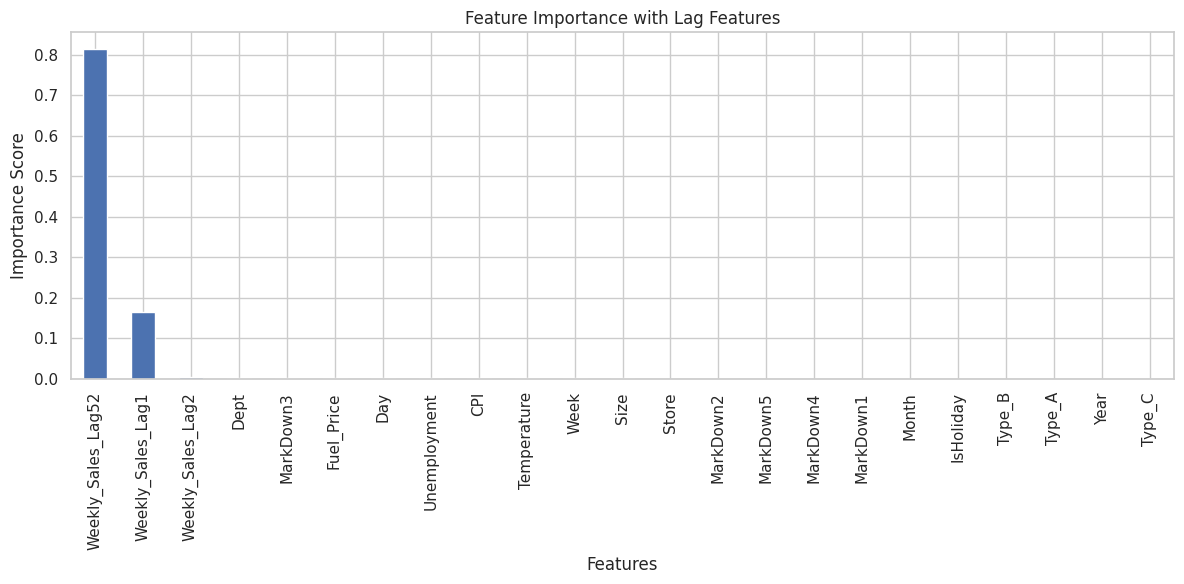

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate feature importance
feature_importance_lag = pd.Series(rf_model_lag.feature_importances_,
                                   index=X_train_features_lag.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_importance_lag.plot(kind='bar')
plt.title('Feature Importance with Lag Features')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

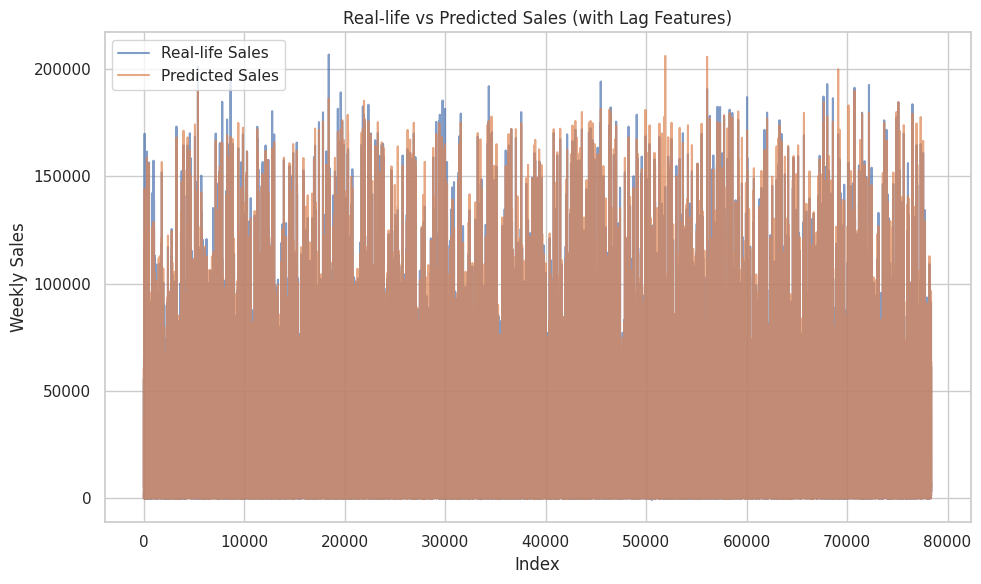

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(y_valid_lag.values, label='Real-life Sales', alpha=0.7)
plt.plot(y_pred_lag, label='Predicted Sales', alpha=0.7)
plt.title('Real-life vs Predicted Sales (with Lag Features)')
plt.ylabel('Weekly Sales')
plt.xlabel('Index')
plt.legend()
plt.tight_layout()
plt.show()

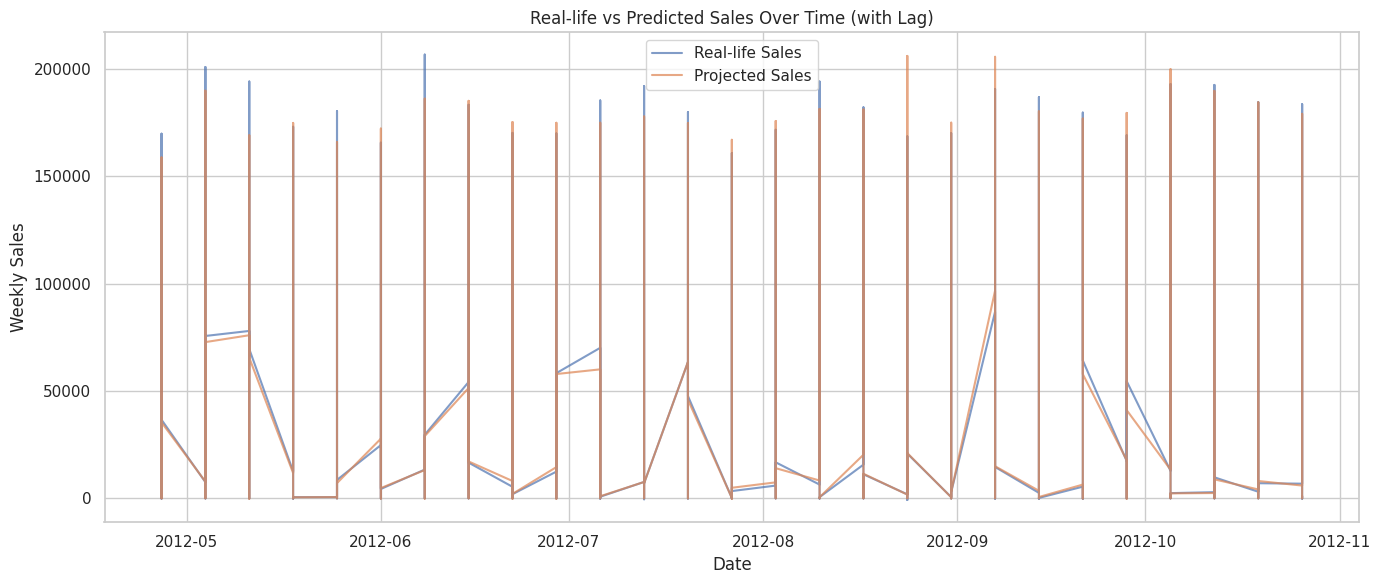

In [87]:
plt.figure(figsize=(14, 6))
plt.plot(X_valid_lag['Date'], y_valid_lag.values, label='Real-life Sales', alpha=0.7)
plt.plot(X_valid_lag['Date'], y_pred_lag, label='Projected Sales', alpha=0.7)
plt.title('Real-life vs Predicted Sales Over Time (with Lag)')
plt.ylabel('Weekly Sales')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

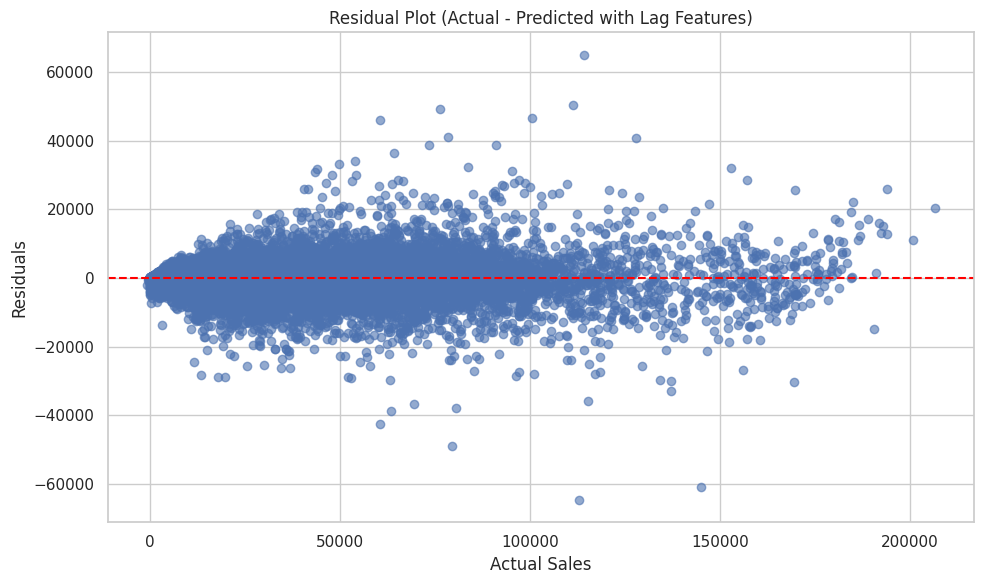

In [88]:
# Residuals
residuals_lag = y_valid_lag.values - y_pred_lag

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_valid_lag.values, residuals_lag, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title('Residual Plot (Actual - Predicted with Lag Features)')
plt.xlabel('Actual Sales')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

In [89]:
rmse_difference = normalized_rmse_lag - normalized_rmse

print(f"Difference in Normalized RMSE (Lag - No Lag): {rmse_difference:.4f}")

Difference in Normalized RMSE (Lag - No Lag): -0.0489


# Feature Engineering

In [90]:
# !pip install shap

In [91]:
# Rename 'ds' in train_df to 'Date' for consistency
train_df.rename(columns={'ds': 'Date'}, inplace=True)


In [92]:
print(features_df.columns)
print(stores_df.columns)
print(train_df.columns)


Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Year', 'Month', 'Week', 'Day'],
      dtype='object')
Index(['Store', 'Type', 'Size'], dtype='object')
Index(['Date', 'y'], dtype='object')


In [93]:
!pip install --upgrade lightgbm


Early stopping at round 138


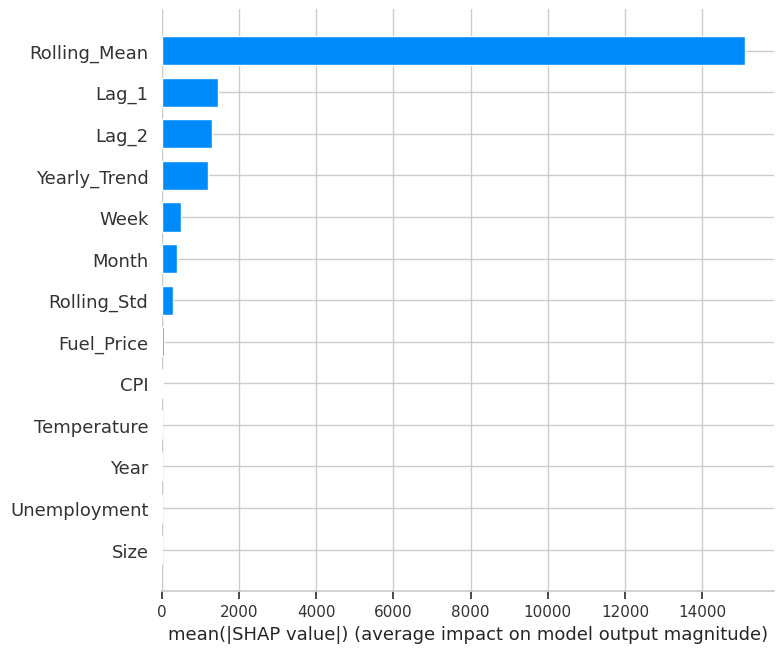

Final RMSE: 3043.9366092155205


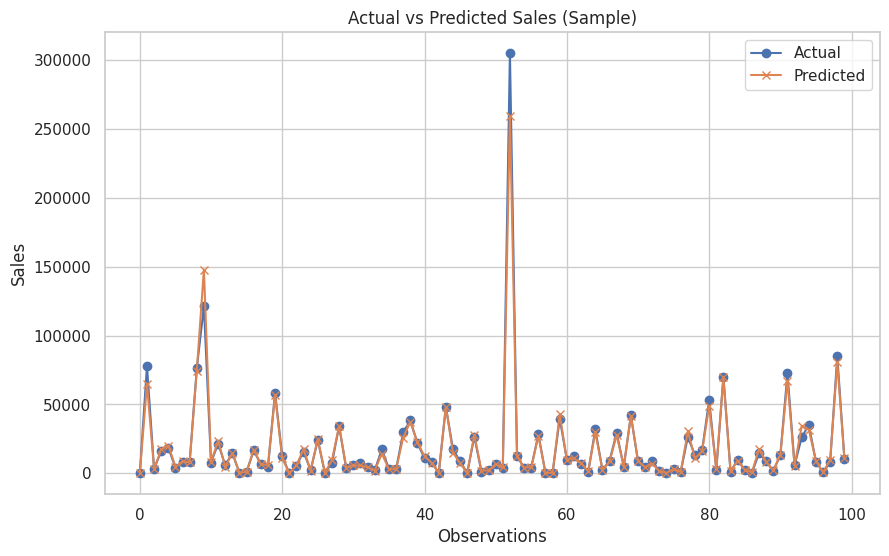

In [94]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# just in case the data was modified for other purposes earlier
features_df = pd.read_csv(f"{path}/features.csv")
stores_df = pd.read_csv(f"{path}/stores.csv")
test_df = pd.read_csv(f"{path}/test.csv")
train_df = pd.read_csv(f"{path}/train.csv")

# Ensure column consistency
features_df.columns = features_df.columns.str.strip()
stores_df.columns = stores_df.columns.str.strip()
train_df.columns = train_df.columns.str.strip()

# Convert 'Date' columns to datetime
features_df['Date'] = pd.to_datetime(features_df['Date'])
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Merge datasets
data = train_df.merge(features_df, on=['Store', 'Date'], how='left')
data = data.merge(stores_df, on='Store', how='left')

# Feature Engineering
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week
data = data.sort_values(['Store', 'Dept', 'Date'])
data['Lag_1'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
data['Rolling_Mean'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean())
data['Lag_2'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
data['Rolling_Std'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4).std())
data['Yearly_Trend'] = data.groupby(['Store', 'Dept', 'Year'])['Weekly_Sales'].transform(lambda x: x.mean())
data = data.dropna()

# Feature Selection
features = ['Year', 'Month', 'Week', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Lag_1', 'Rolling_Mean', 'Lag_2', 'Rolling_Std', 'Yearly_Trend', 'Size']
target = 'Weekly_Sales'
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'verbose': -1
}


# Manual early stopping workaround
best_rmse = float('inf')
num_boost_round = 1000
early_stopping_rounds = 50
rmse_list = []

for i in range(1, num_boost_round + 1):
    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        init_model=None,
        num_boost_round=i,
    )

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

    if i > early_stopping_rounds and rmse > min(rmse_list[-early_stopping_rounds:]):
        print(f"Early stopping at round {i}")
        break


# SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Final Predictions and evaluation
y_pred = model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE: {final_rmse}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label="Actual", marker='o')
plt.plot(y_pred[:100], label="Predicted", marker='x')
plt.title("Actual vs Predicted Sales (Sample)")
plt.xlabel("Observations")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

# Model Comparison

| Model     | RMSE |
|-----------|------|
| AutoRegressor | 7124.06 |
| Prohpet Model   | 4184.91 |
| Light Gradient Boosting Model   | 9737.26 |
| Random Forest Baseline     |  3424.10    |
| LGB Model after Shap     |  3043.94   |
| Random Forest with Lag Features       | 2700.35 |

# Final Thoughts

* The Random Forest with lagging performed much better than all other models. We were able to predict sales accurately. The key deliverables were met throughout the notebook. For Random Forests, we considered hyperparameter tuning and feature engineering but we ended up moving forward with Feature Lagging. We would however recommend exploring those approaches as well.